In [1]:
import sys
import os

sys.path.append(os.path.abspath('..'))

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import commons as cmns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import Audio
sound_file = 'beep.wav'

In [3]:
data=pd.read_csv('../btc_data.csv',sep=',')
data.head()
data.isna().sum().sum() # There is no missing value ...

0

# Interpolation (Data imputation)

In [4]:
# Is this really necessary?
data.interpolate(axis=0,inplace=True)

# Boolean Masks for each interval

In [5]:
interval1 = (data['Date'] >= '2013/04/01') & (data['Date'] <= '2016/07/19')
interval2=(data['Date'] >= '2013/04/01') & (data['Date'] <= '2017/04/01')
interval3=(data['Date'] >= '2013/04/01') & (data['Date'] <= '2019/12/31')

intervals_masks_map = {
    "interval1": interval1, 
    "interval2": interval2, 
    "interval3": interval3,
    }

# Shifting price col for each horizon

In [6]:
one=data['priceUSD'].shift(-1,fill_value=1)
seven=data['priceUSD'].shift(-7,fill_value=1)
fourteen=data['priceUSD'].shift(-14,fill_value=1)
thirty=data['priceUSD'].shift(-30,fill_value=1)
sixty=data['priceUSD'].shift(-60,fill_value=1)
ninety=data['priceUSD'].shift(-90,fill_value=1)

one.head()

0    0.0726
1    0.0859
2    0.0783
3    0.0767
4    0.0649
Name: priceUSD, dtype: float64

In [7]:
shifted_prices_map = {
    "1": one,
    "7": seven,
    "14": fourteen,
    "30": thirty,
    "60": sixty,
    "90": ninety,
}

# For Interval 1: 01/04/2013 ~ 19/07/2019

## Create category column

In [8]:
interval = "interval1"
shifting = "1"

In [14]:
df = data.loc[
    intervals_masks_map[interval]
]

df = df.assign(
    shifted=
    shifted_prices_map[shifting].loc[intervals_masks_map[interval]]
    )

df.loc[:, 'difference']=((df['shifted']-df['priceUSD'])/df['shifted'])*100
df.reset_index(drop=True,inplace=True)
df.loc[:, "category"] = df['difference']>=0
df["category"].replace({
        True: 1,
        False: 0
    },
    inplace=True
    )
df["category"].sum()

638

In [15]:
df.drop(columns=['shifted','difference'],inplace=True)
df.head()

Date  priceUSD  transactions      size  sentbyaddress  difficulty  \
0  2013/04/01    94.715         52572  139256.0          48809   6695826.0   
1  2013/04/02   107.749         63095  175443.0          62276   6695826.0   
2  2013/04/03   120.003         63766  184209.0          69174   6695826.0   
3  2013/04/04   123.562         66738  221568.0          71753   6695826.0   
4  2013/04/05   128.664         61215  190067.0          69310   7005058.0   

       hashrate  mining_profitability  sentinusdUSD  transactionfeesUSD  ...  \
0  6.550211e+13                7220.0   136779480.0              0.0777  ...   
1  6.184560e+13                7990.0   278422775.0              0.1050  ...   
2  6.027037e+13                8852.0   284039909.0              0.1330  ...   
3  5.527246e+13                8777.0   282809750.0              0.1410  ...   
4  5.181545e+13                9950.0   264855827.0              0.1200  ...   

   price7rsiUSD  price14rsiUSD  price30rsiUSD  price90rsiUSD  price3rocUSD  \
0        96.992         95.075         93.774         91.450         9.383   
1        98.201         96.416         94.987         92.645        23.206   
2        98.752         97.190         95.785         93.508        34.759   
3        98.869         97.368         95.977         93.724        30.456   
4        99.022         97.602         96.233         94.013        19.411   

   price7rocUSD  price14rocUSD  price30rocUSD  price90rocUSD  category  
0        36.980        104.747        185.993        606.456         1  
1        50.270        109.704        231.964        716.218         1  
2        51.448        107.789        259.795        808.284         1  
3        44.093         93.098        237.355        834.762         1  
4        48.589         95.718        229.992        876.762         1  

[5 rows x 738 columns]

## Feature Selection

In [16]:
USD=df['priceUSD']

In [17]:
X_raw=df.iloc[:,2:17]
X_raw.head()

transactions      size  sentbyaddress  difficulty      hashrate  \
0         52572  139256.0          48809   6695826.0  6.550211e+13   
1         63095  175443.0          62276   6695826.0  6.184560e+13   
2         63766  184209.0          69174   6695826.0  6.027037e+13   
3         66738  221568.0          71753   6695826.0  5.527246e+13   
4         61215  190067.0          69310   7005058.0  5.181545e+13   

   mining_profitability  sentinusdUSD  transactionfeesUSD  \
0                7220.0   136779480.0              0.0777   
1                7990.0   278422775.0              0.1050   
2                8852.0   284039909.0              0.1330   
3                8777.0   282809750.0              0.1410   
4                9950.0   264855827.0              0.1200   

   median_transaction_feeUSD  confirmationtime  transactionvalueUSD  \
0                     0.0474             7.273               2592.0   
1                     0.0539             7.956               4400.0   
2                     0.0600             8.229               4478.0   
3                     0.0618             9.351               4249.0   
4                     0.0643             9.114               4348.0   

   mediantransactionvalueUSD  activeaddresses  top100cap  fee_to_rewardUSD  
0                     64.987            75756     19.962             0.867  
1                     94.955            91875     20.024             1.338  
2                    102.533           107142     19.987             1.596  
3                    123.314           108890     19.990             1.948  
4                    125.183           100034     19.833             1.432

In [18]:
# Category Array
y=df.loc[:, "category"]
y=np.ravel(y)
y

array([1, 1, 1, ..., 1, 0, 0])

## Run Random Forest for Feature Scores

In [19]:
features_list=[]
technical_indicators=['sma','ema','wma','trx','mom','std','var','rsi','roc']
periods=['3','7','14','30','90']
for i in technical_indicators:
    for j in periods:
        string=str(j)+str(i)
        X=df.filter(like=string,axis=1)
        X=SimpleImputer(missing_values=0,strategy='most_frequent').fit_transform(X)
        X=pd.DataFrame(X)
        X.columns=df.filter(like=string,axis=1).columns
        rf1=RandomForestClassifier(random_state=7,n_jobs=-1)
        rfecv=RFECV(rf1,step=0.9,min_features_to_select=1,verbose=0,cv=5,scoring='neg_mean_absolute_error', n_jobs=-1)
        rfecv.fit(X,y)
        if rfecv.n_features_>1:
            rf1.fit(X,y)
            maximp=rf1.feature_importances_.max()
            for x in range(len(rf1.feature_importances_)):
                if maximp==rf1.feature_importances_[x]:
                    new_features = [X.columns[x]]
        else:
            mask = rfecv.get_support()
            new_features = X.columns[mask].array
        features_list.extend(new_features)
        # print(string+': '+new_features)

In [20]:
# Not needed anymore. Same as feature_list.
l1=[]
for j in range(len(features_list)):
    result1 = re.search("'(.*)'],", features_list[j])
    if result1!=None:
        l1.append(result1.group(1))
for i in range(len(features_list)):
    result2 = re.search('.*',features_list[i])
    if len(result2.group(0))<33:
        l1.append(result2.group(0))

l1.sort()
df_reduced=df[l1]
df_reduced.head()

activeaddresses3trx  activeaddresses90var  confirmationtime14ema  \
0               -1.376              82659141                  8.263   
1                1.849              93587018                  8.222   
2                6.045             119931071                  8.223   
3                7.371             146568407                  8.373   
4                5.263             164680970                  8.472   

   confirmationtime14sma  confirmationtime30ema  confirmationtime3ema  \
0                  8.088                  8.368                 7.883   
1                  8.051                  8.341                 7.920   
2                  8.152                  8.334                 8.074   
3                  8.348                  8.399                 8.712   
4                  8.550                  8.446                 8.913   

   confirmationtime7ema  confirmationtime7sma  confirmationtime7wma  \
0                 8.213                 8.684                 8.282   
1                 8.149                 8.459                 8.099   
2                 8.169                 8.064                 8.042   
3                 8.464                 8.275                 8.364   
4                 8.627                 8.395                 8.573   

   difficulty14std  ...  sentinusd90wmaUSD  size14var  size30sma  size7rsi  \
0        1745325.0  ...           73371893  673384639   154996.0    42.217   
1        1667845.0  ...           78292153  689152619   155608.0    56.876   
2        1542023.0  ...           83274140  555653079   156259.0    59.760   
3        1354453.0  ...           88165336  721463920   157161.0    69.804   
4        1102088.0  ...           92600382  660679155   157013.0    56.043   

   size90mom  size90sma  transactionfees14rsiUSD  transactionfees30rsiUSD  \
0    50223.0   154528.0                   56.505                   56.924   
1    61367.0   155210.0                   64.356                   61.462   
2    76185.0   156056.0                   70.496                   65.489   
3    79757.0   156943.0                   71.958                   66.506   
4    71827.0   157741.0                   63.194                   61.622   

   transactions90ema  transactions90std  
0            51153.0            16078.0  
1            51415.0            15980.0  
2            51687.0            15982.0  
3            52017.0            16206.0  
4            52220.0            16024.0  

[5 rows x 45 columns]

In [ ]:
X=cmns.drop_high_vif(df_reduced,thresh=5, print_result=False)
cmns.vif_values(X)
X.shape

Raw=cmns.drop_high_vif(X_raw,thresh=10)
cmns.vif_values(Raw)
Raw.loc[:, 'Date']=df['Date']
X['Date']=df['Date']
df_merged=Raw.merge(X.drop_duplicates(subset='Date'),how='left')
df_merged.drop(columns='Date',inplace=True)
X=cmns.drop_high_vif(df_merged,thresh=5)
X.shape

cmns.vif_values(X)
if 'priceUSD' not in X.columns:
    X['priceUSD']=USD

rf_final=RandomForestClassifier(random_state=7,n_jobs=-1)
rf_final.fit(X,y)
imp_feat=cmns.feature_importance(X.columns,rf_final.feature_importances_)
cmns.plot_feature_importance(imp_feat,'feature importance')
plt.show()

In [24]:
# from matplotlib import rcParams

# def plot_feature_importance(imp_df, title):
#     # figure size in inches
#     rcParams['figure.figsize'] = 11.7,8.27
#     imp_df.columns = ['feature', 'feature_importance']
#     sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, color = 'royalblue') \
#        .set_title(title, fontsize = 20)

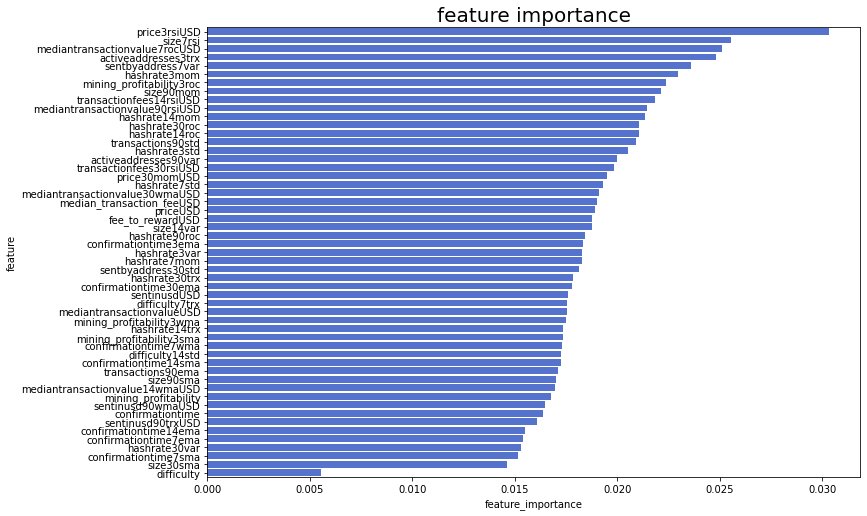

In [40]:
rf_final=RandomForestClassifier(random_state=7,n_jobs=-1)
rf_final.fit(X,y)
imp_feat=cmns.feature_importance(X.columns,rf_final.feature_importances_)
cmns.plot_feature_importance(imp_feat,'feature importance')
plt.show()

In [ ]:
imp_feat_cumsum = imp_feat.copy()
imp_feat_cumsum.loc[:, "feature_importance_cumsum"] = imp_feat_cumsum["feature_importance"].expanding(1).sum()
imp_feat_cumsum

> **Columns are manually selected but with what criteria?** Maybe we can use accumulated feature importance to choose the features. For instance, we can consider up to 80% for feature importance

In [ ]:
cols=[7,12,14,18,20,24,28,29,30,38,42,46]
imp_feat

In [28]:
# selected=imp_feat[imp_feat['feature_importance']>0.001]
# selected=imp_feat.filter(cols,axis=0)

In [ ]:
selected=imp_feat.drop(cols,axis=0)
print(selected.feature_importance.sum())
selected

In [57]:
select_with_cumsum = imp_feat_cumsum[imp_feat_cumsum["feature_importance_cumsum"] <= 0.80]
select_with_cumsum.feature_importance.sum()
X_high_cumsum=X[select_with_cumsum.feature]
X_high_cumsum.shape

(1206, 39)

In [142]:
X_high=X[selected.feature]
X_high.sort_index(axis=1,inplace=True)

corr = X_high.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(26, 13))

sns.heatmap(corr,mask=mask, cmap='coolwarm',annot=True, fmt='.2f')

In [143]:
X_high.shape

(1206, 40)

<AxesSubplot:>

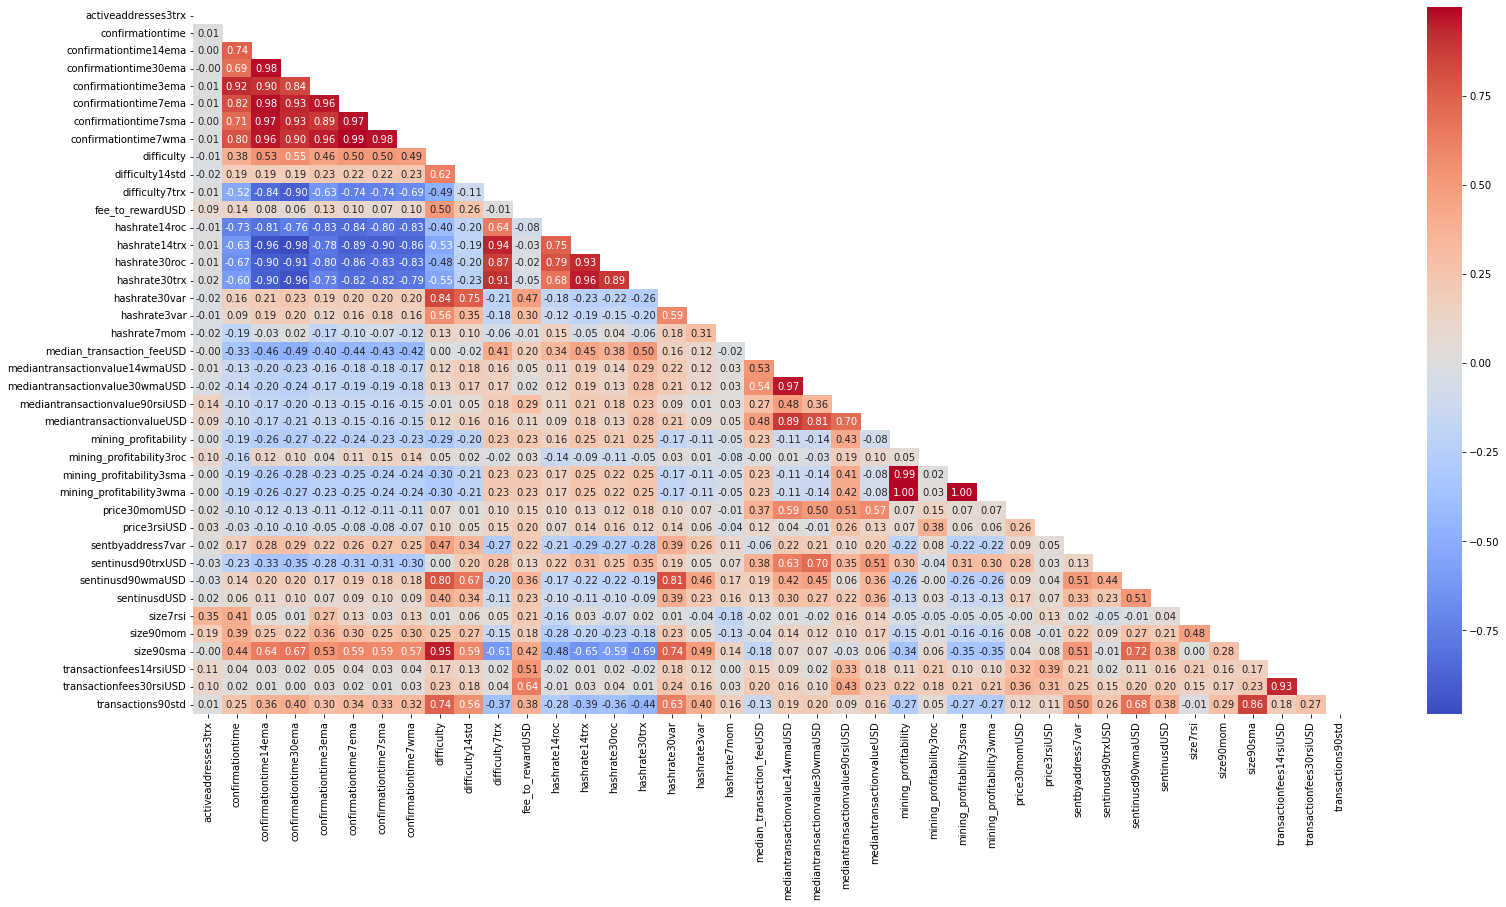

In [145]:
# corr = X_high.corr()
# # Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr, dtype=np.bool))

# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(26, 13))

# sns.heatmap(corr,mask=mask, cmap='coolwarm',annot=True, fmt='.2f')

In [147]:
X_high['category']=np.ravel(y)

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [148]:
from sklearn.ensemble import IsolationForest
outlier=IsolationForest(contamination=0)
category=X_high['category']
category=category.values
category=np.reshape(category,(-1,1))
outlier.fit(category)
outs=outlier.predict(category)
X_high['outlier']=pd.DataFrame(zip(outs))
X_high=X_high.query('outlier != -1')
X_high.reset_index(drop=True,inplace=True)
X_high.drop(columns=['outlier'],inplace=True)

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [149]:
X_high.to_csv(f'cls_{interval}_{shifting}days.csv',sep=',',index=False)

In [150]:
X_high.columns

Index(['activeaddresses3trx', 'confirmationtime', 'confirmationtime14ema',
       'confirmationtime30ema', 'confirmationtime3ema', 'confirmationtime7ema',
       'confirmationtime7sma', 'confirmationtime7wma', 'difficulty',
       'difficulty14std', 'difficulty7trx', 'fee_to_rewardUSD',
       'hashrate14roc', 'hashrate14trx', 'hashrate30roc', 'hashrate30trx',
       'hashrate30var', 'hashrate3var', 'hashrate7mom',
       'median_transaction_feeUSD', 'mediantransactionvalue14wmaUSD',
       'mediantransactionvalue30wmaUSD', 'mediantransactionvalue90rsiUSD',
       'mediantransactionvalueUSD', 'mining_profitability',
       'mining_profitability3roc', 'mining_profitability3sma',
       'mining_profitability3wma', 'price30momUSD', 'price3rsiUSD',
       'sentbyaddress7var', 'sentinusd90trxUSD', 'sentinusd90wmaUSD',
       'sentinusdUSD', 'size7rsi', 'size90mom', 'size90sma',
       'transactionfees14rsiUSD', 'transactionfees30rsiUSD',
       'transactions90std', 'category'],
      dtype=

# Applying for All Intervals

dropping 'hashrate' at index: 4
dropping 'sentbyaddress' at index: 2
dropping 'top100cap' at index: 11
dropping 'transactions' at index: 0
dropping 'size' at index: 0
dropping 'transactionvalueUSD' at index: 6
dropping 'activeaddresses' at index: 7
dropping 'transactionfeesUSD' at index: 3
Remaining variables:
Index(['difficulty', 'mining_profitability', 'sentinusdUSD',
       'median_transaction_feeUSD', 'confirmationtime',
       'mediantransactionvalueUSD', 'fee_to_rewardUSD'],
      dtype='object')


/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Remaining variables:
Index(['difficulty', 'mining_profitability', 'sentinusdUSD',
       'median_transaction_feeUSD', 'confirmationtime',
       'mediantransactionvalueUSD', 'fee_to_rewardUSD', 'activeaddresses3trx',
       'activeaddresses90var', 'confirmationtime14ema',
       'confirmationtime14sma', 'confirmationtime30ema',
       'confirmationtime3ema', 'confirmationtime7ema', 'confirmationtime7sma',
       'confirmationtime7wma', 'difficulty14std', 'difficulty7trx',
       'hashrate14mom', 'hashrate14roc', 'hashrate14trx', 'hashrate30roc',
       'hashrate30trx', 'hashrate30var', 'hashrate3mom', 'hashrate3std',
       'hashrate3var', 'hashrate7mom', 'hashrate7std', 'hashrate90roc',
       'mediantransactionvalue14wmaUSD', 'mediantransactionvalue30wmaUSD',
       'mediantransactionvalue7rocUSD', 'mediantransactionvalue90rsiUSD',
       'mining_profitability3roc', 'mining_profitability3sma',
       'mining_profitability3wma', 'price30momUSD', 'price3rsiUSD',
       'sentbyaddress30

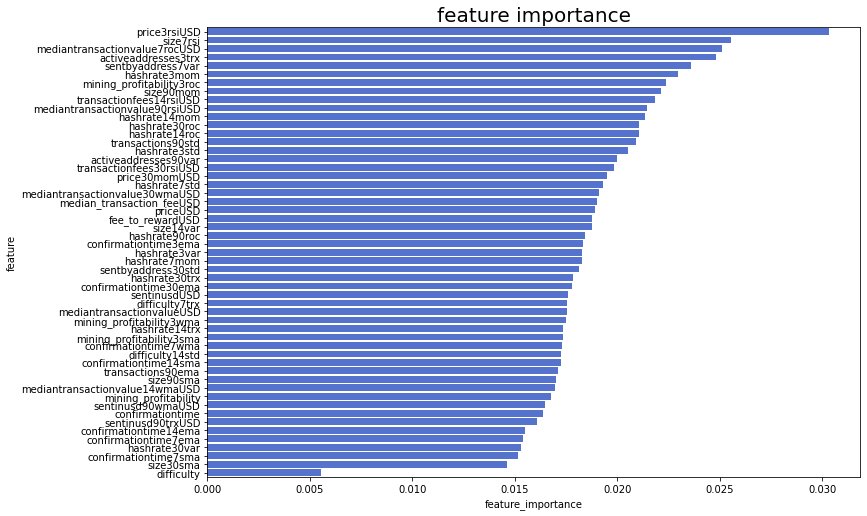

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


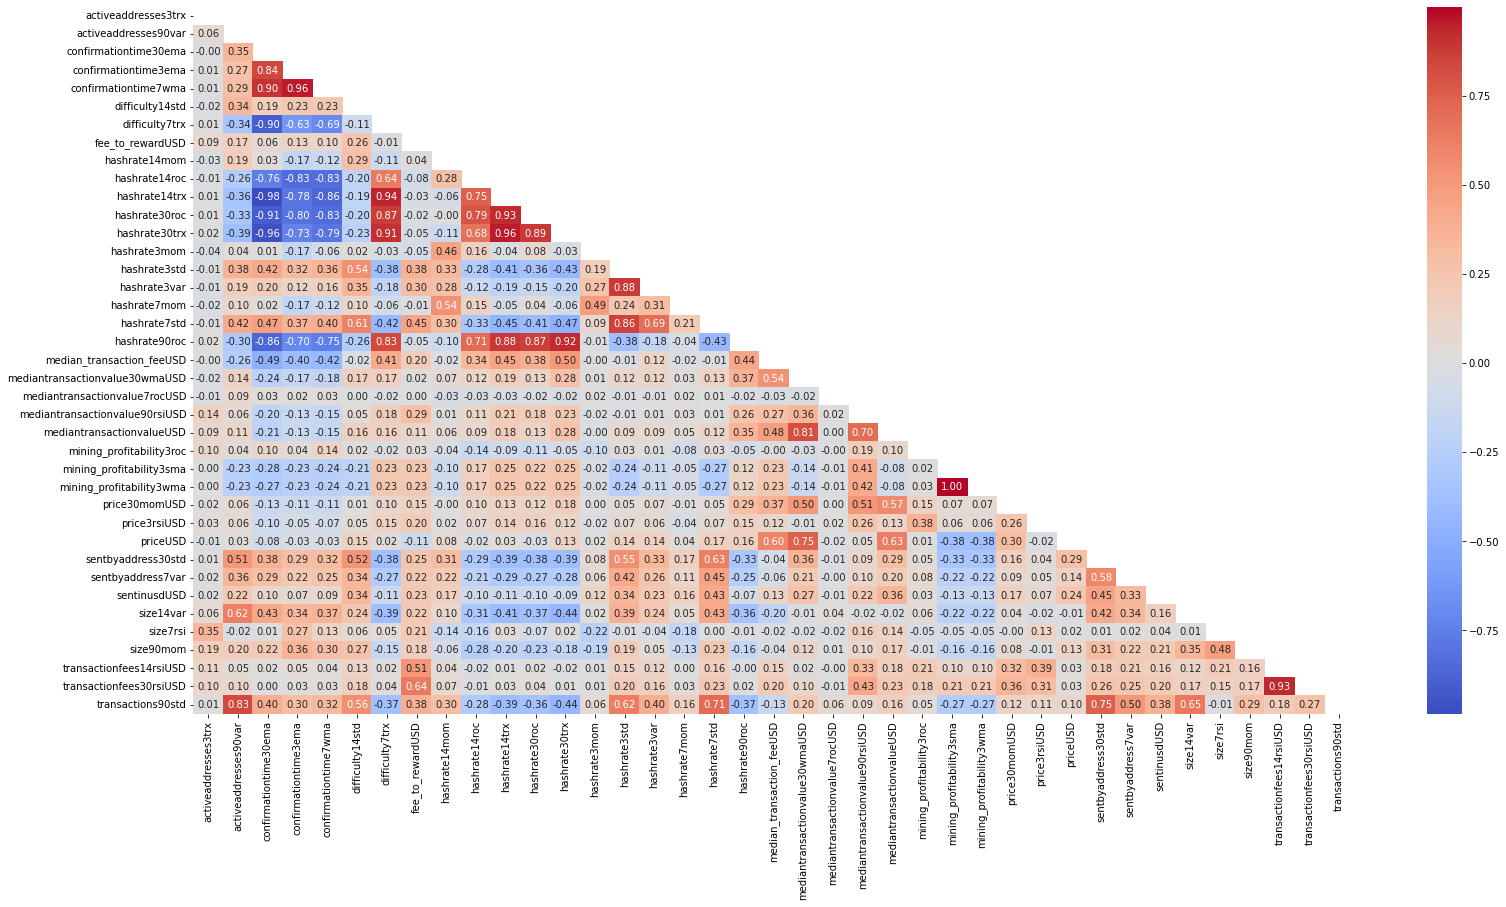

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


dropping 'hashrate' at index: 4
dropping 'sentbyaddress' at index: 2
dropping 'top100cap' at index: 11
dropping 'transactions' at index: 0
dropping 'size' at index: 0
dropping 'transactionvalueUSD' at index: 6
dropping 'activeaddresses' at index: 7
dropping 'transactionfeesUSD' at index: 3
Remaining variables:
Index(['difficulty', 'mining_profitability', 'sentinusdUSD',
       'median_transaction_feeUSD', 'confirmationtime',
       'mediantransactionvalueUSD', 'fee_to_rewardUSD'],
      dtype='object')


/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Remaining variables:
Index(['difficulty', 'mining_profitability', 'sentinusdUSD',
       'median_transaction_feeUSD', 'confirmationtime',
       'mediantransactionvalueUSD', 'fee_to_rewardUSD', 'activeaddresses30trx',
       'difficulty14ema', 'difficulty14wma', 'difficulty30ema',
       'difficulty3ema', 'difficulty7ema', 'hashrate14std', 'hashrate14var',
       'hashrate3var', 'hashrate7mom', 'hashrate7var',
       'median_transaction_fee3trxUSD', 'mediantransactionvalue7rocUSD',
       'mining_profitability14sma', 'mining_profitability30sma',
       'mining_profitability30wma', 'mining_profitability3sma',
       'mining_profitability3std', 'mining_profitability3wma',
       'mining_profitability7sma', 'mining_profitability7std',
       'mining_profitability7wma', 'mining_profitability90ema',
       'mining_profitability90trx', 'price14rsiUSD', 'price30stdUSD',
       'price30varUSD', 'price3momUSD', 'price3rocUSD', 'price3rsiUSD',
       'price7rsiUSD', 'price90smaUSD', 'sentinusd90

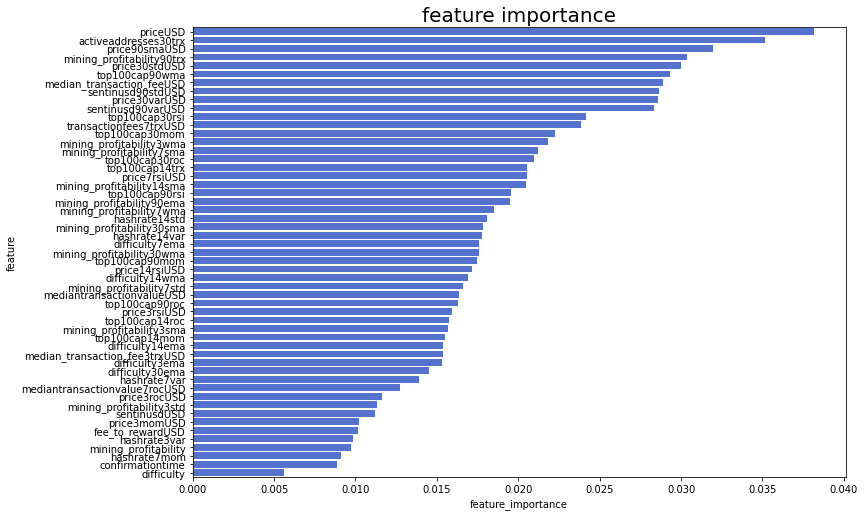

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


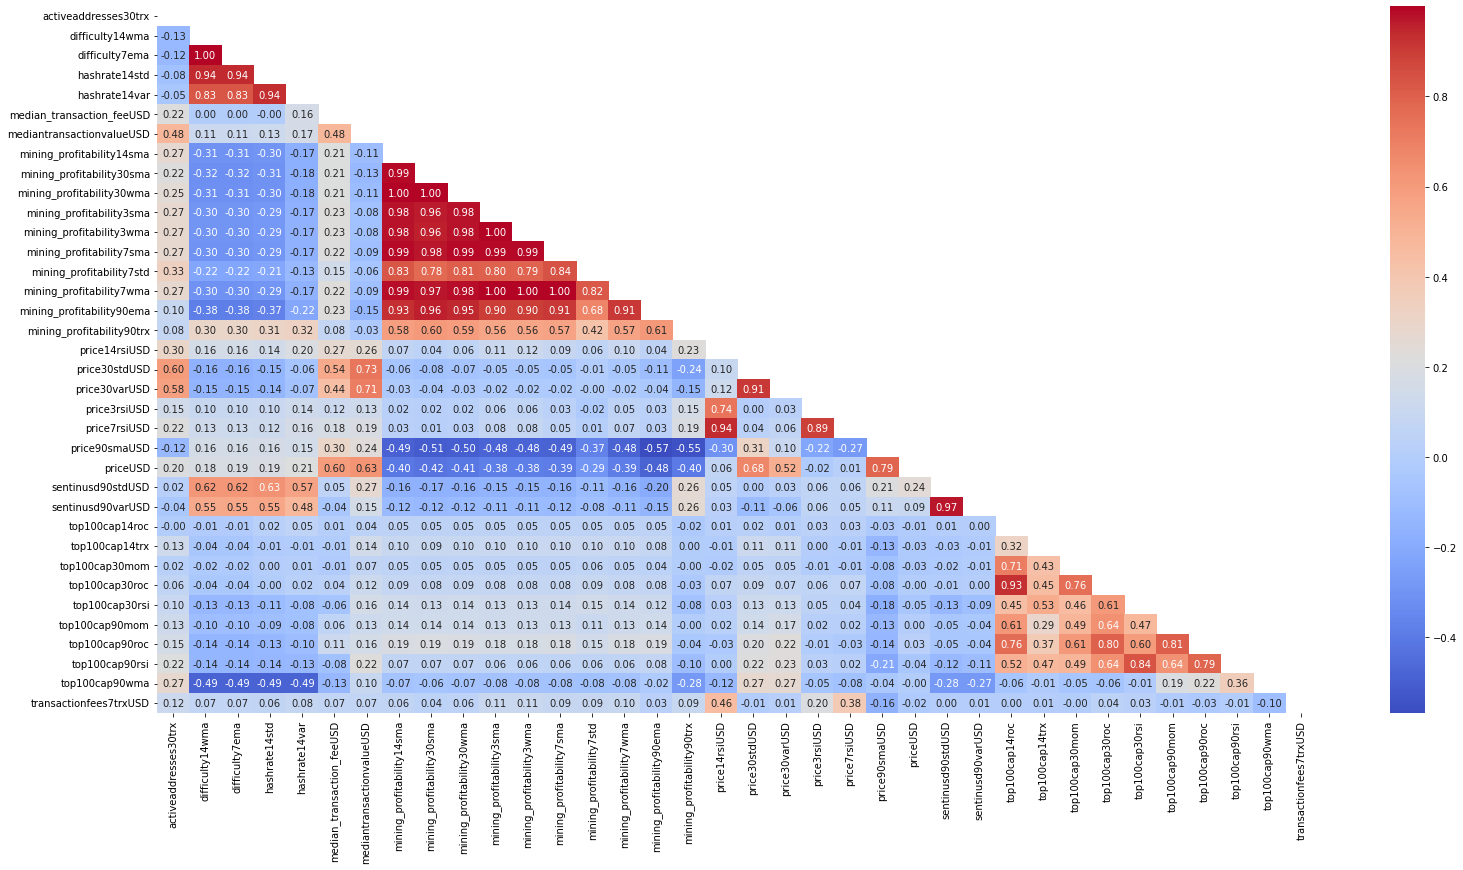

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


dropping 'hashrate' at index: 4
dropping 'sentbyaddress' at index: 2
dropping 'top100cap' at index: 11
dropping 'transactions' at index: 0
dropping 'size' at index: 0
dropping 'transactionvalueUSD' at index: 6
dropping 'activeaddresses' at index: 7
dropping 'transactionfeesUSD' at index: 3
Remaining variables:
Index(['difficulty', 'mining_profitability', 'sentinusdUSD',
       'median_transaction_feeUSD', 'confirmationtime',
       'mediantransactionvalueUSD', 'fee_to_rewardUSD'],
      dtype='object')


/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Remaining variables:
Index(['difficulty', 'mining_profitability', 'sentinusdUSD',
       'median_transaction_feeUSD', 'confirmationtime',
       'mediantransactionvalueUSD', 'fee_to_rewardUSD', 'difficulty14ema',
       'difficulty14mom', 'difficulty14roc', 'difficulty14sma',
       'difficulty14var', 'difficulty14wma', 'difficulty30roc',
       'difficulty30wma', 'difficulty3ema', 'difficulty3sma', 'difficulty3wma',
       'difficulty7ema', 'difficulty7trx', 'difficulty7wma', 'difficulty90mom',
       'difficulty90roc', 'fee_to_reward7smaUSD', 'fee_to_reward90emaUSD',
       'fee_to_reward90wmaUSD', 'hashrate30trx', 'hashrate3std',
       'hashrate3var', 'hashrate7std', 'hashrate7var',
       'median_transaction_fee3rsiUSD', 'mining_profitability30sma',
       'mining_profitability90trx', 'price14rsiUSD', 'price30stdUSD',
       'price3momUSD', 'price3rocUSD', 'price7rsiUSD', 'price90smaUSD',
       'sentinusd90varUSD', 'size14std', 'size30ema', 'top100cap14trx',
       'top100cap30mo

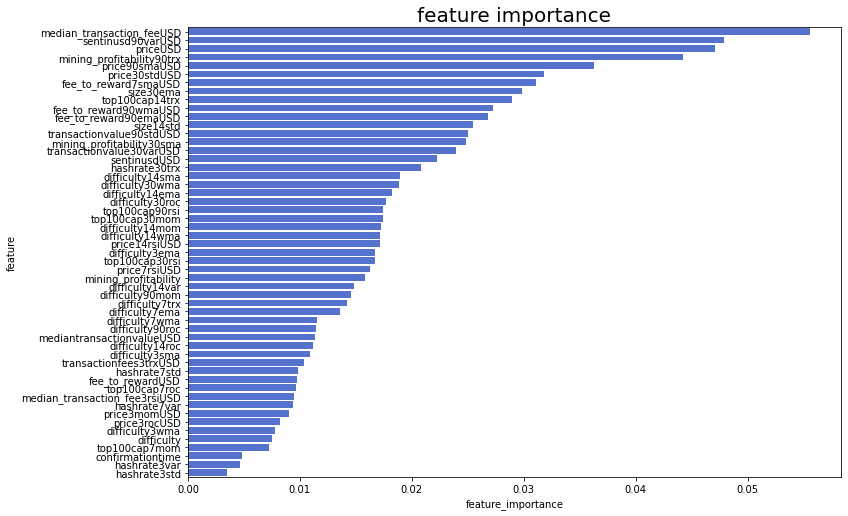

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


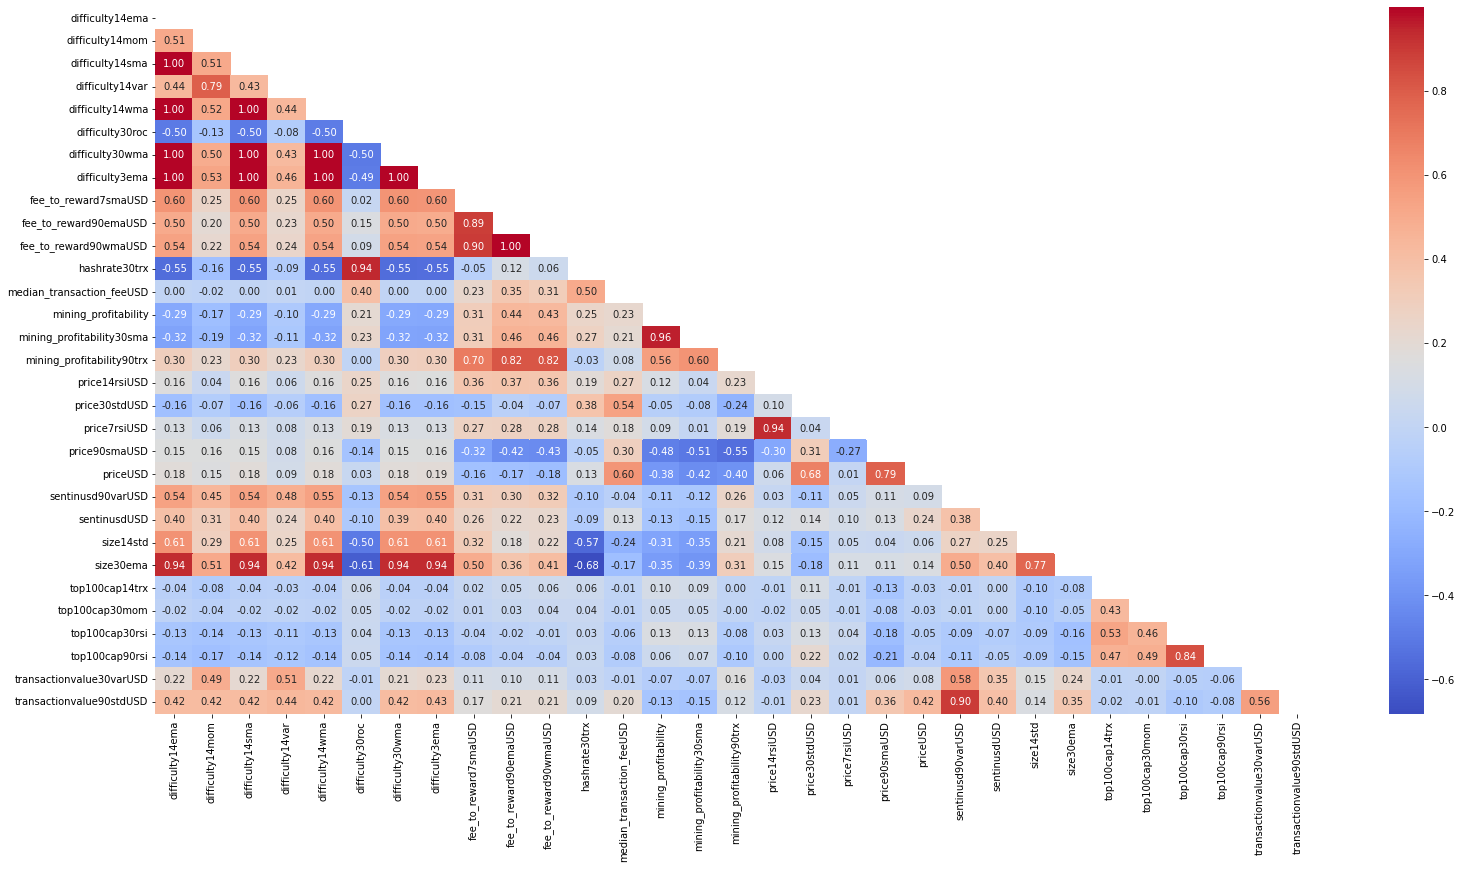

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


dropping 'hashrate14std' at index: 15
dropping 'hashrate' at index: 4
dropping 'sentbyaddress' at index: 2
dropping 'top100cap' at index: 11
dropping 'transactions' at index: 0
dropping 'size' at index: 0
dropping 'transactionvalueUSD' at index: 6
dropping 'activeaddresses' at index: 7
dropping 'transactionfeesUSD' at index: 3
Remaining variables:
Index(['difficulty', 'mining_profitability', 'sentinusdUSD',
       'median_transaction_feeUSD', 'confirmationtime',
       'mediantransactionvalueUSD', 'fee_to_rewardUSD'],
      dtype='object')


/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Remaining variables:
Index(['difficulty', 'mining_profitability', 'sentinusdUSD',
       'median_transaction_feeUSD', 'confirmationtime',
       'mediantransactionvalueUSD', 'fee_to_rewardUSD', 'difficulty14mom',
       'difficulty14roc', 'difficulty14sma', 'difficulty14trx',
       'difficulty14wma', 'difficulty30mom', 'difficulty30roc',
       'difficulty3ema', 'difficulty3trx', 'difficulty7ema', 'difficulty7roc',
       'difficulty7trx', 'difficulty7wma', 'difficulty90var',
       'fee_to_reward30stdUSD', 'hashrate14var', 'hashrate30trx',
       'hashrate3std', 'hashrate3var', 'hashrate7mom', 'hashrate7std',
       'hashrate7var', 'median_transaction_fee90rocUSD',
       'mining_profitability30ema', 'mining_profitability30sma',
       'mining_profitability90trx', 'mining_profitability90wma',
       'price14emaUSD', 'price30varUSD', 'price30wmaUSD', 'price3momUSD',
       'price3rocUSD', 'price3rsiUSD', 'price3smaUSD', 'price3wmaUSD',
       'price7rsiUSD', 'price7smaUSD', 'price90em

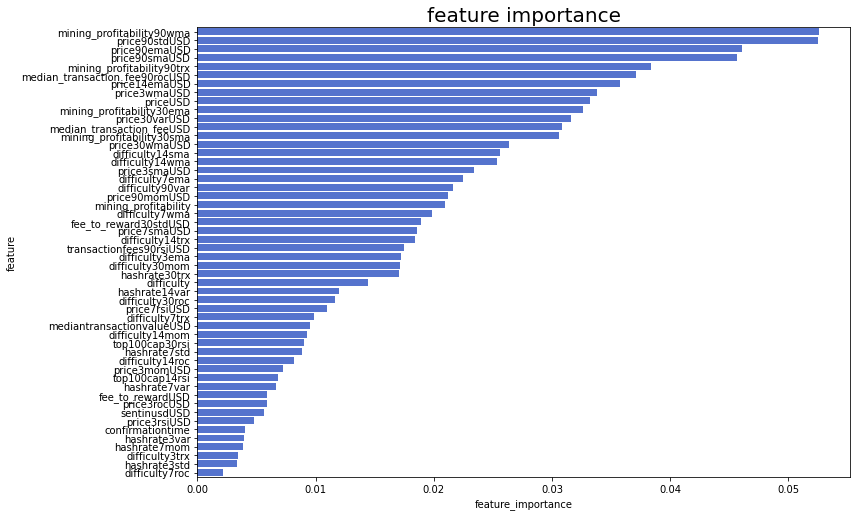

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


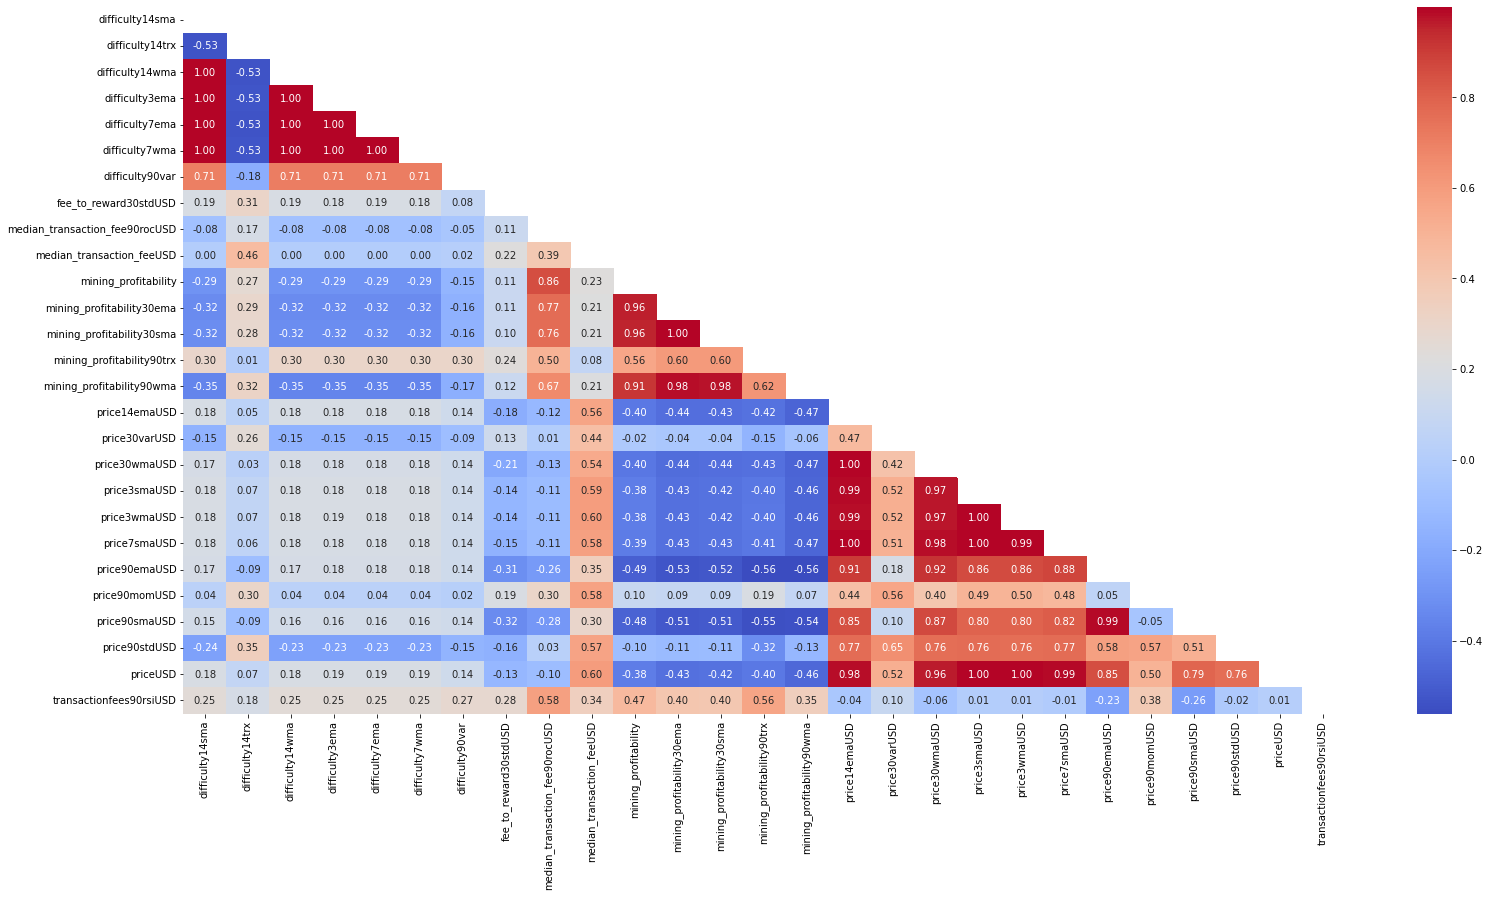

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


dropping 'hashrate3var' at index: 11
dropping 'difficulty14sma' at index: 2
dropping 'difficulty30sma' at index: 5
dropping 'difficulty7wma' at index: 6
dropping 'transactions90sma' at index: 39
dropping 'mining_profitability7sma' at index: 21
dropping 'mining_profitability14std' at index: 12
dropping 'sentinusd90varUSD' at index: 30
dropping 'mining_profitability14ema' at index: 11
dropping 'mining_profitability3sma' at index: 17
dropping 'price7emaUSD' at index: 25
dropping 'mining_profitability14wma' at index: 12
dropping 'price3emaUSD' at index: 22
dropping 'mining_profitability30ema' at index: 12
dropping 'mining_profitability30std' at index: 13
dropping 'difficulty90wma' at index: 6
dropping 'hashrate7std' at index: 8
dropping 'hashrate' at index: 4
dropping 'sentbyaddress' at index: 2
dropping 'top100cap' at index: 11
dropping 'transactions' at index: 0
dropping 'size' at index: 0
dropping 'transactionvalueUSD' at index: 6
dropping 'activeaddresses' at index: 7
dropping 'transac

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be 

dropping 'difficulty' at index: 0
Remaining variables:
Index(['sentinusdUSD', 'median_transaction_feeUSD', 'confirmationtime',
       'mediantransactionvalueUSD', 'fee_to_rewardUSD', 'difficulty14mom',
       'difficulty14roc', 'difficulty14trx', 'difficulty30mom',
       'difficulty30roc', 'difficulty7trx', 'hashrate3std', 'hashrate7mom',
       'median_transaction_fee90rocUSD', 'mining_profitability14var',
       'mining_profitability30rsi', 'mining_profitability30trx',
       'mining_profitability3wma', 'mining_profitability7var',
       'mining_profitability90rsi', 'price14rsiUSD', 'price30varUSD',
       'price30wmaUSD', 'price3momUSD', 'price7rsiUSD', 'sentinusd90stdUSD',
       'size90ema', 'top100cap3roc', 'top100cap3rsi', 'top100cap3trx',
       'top100cap7roc', 'top100cap90mom', 'transactionvalue90trxUSD'],
      dtype='object')


/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


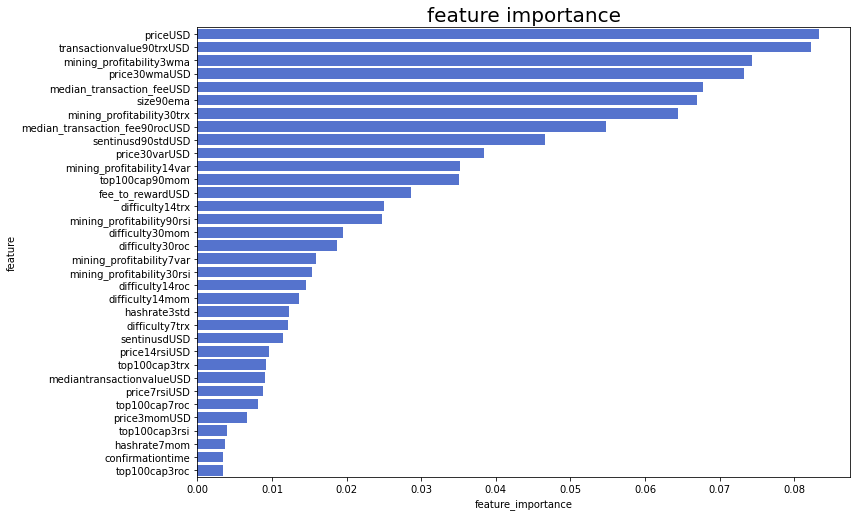

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


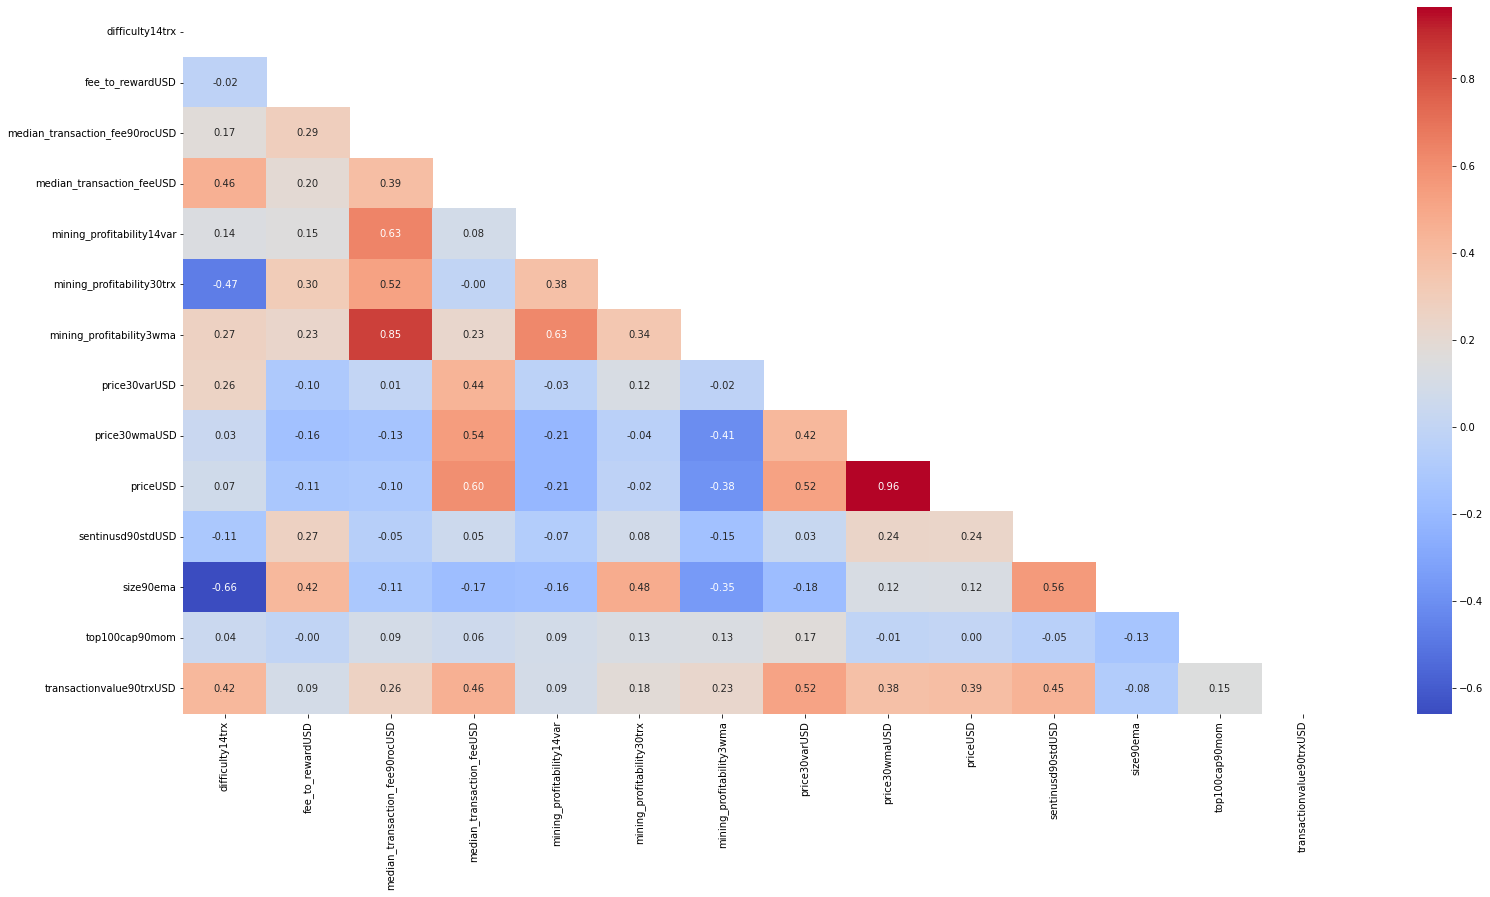

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


dropping 'difficulty7ema' at index: 10
dropping 'difficulty14wma' at index: 3
dropping 'difficulty7wma' at index: 10
dropping 'difficulty30ema' at index: 3
dropping 'difficulty14sma' at index: 2
dropping 'hashrate90wma' at index: 13
dropping 'price3wmaUSD' at index: 27
dropping 'difficulty90ema' at index: 8
dropping 'difficulty3ema' at index: 5
dropping 'difficulty30sma' at index: 4
dropping 'price14emaUSD' at index: 20
dropping 'top100cap14rsi' at index: 26
dropping 'difficulty7sma' at index: 5
dropping 'top100cap30rsi' at index: 25
dropping 'mining_profitability7std' at index: 15
dropping 'price90stdUSD' at index: 22
dropping 'difficulty90rsi' at index: 5
dropping 'top100cap7roc' at index: 24
dropping 'top100cap7rsi' at index: 24
dropping 'hashrate14trx' at index: 7
dropping 'mining_profitability3std' at index: 11
dropping 'price3smaUSD' at index: 17
dropping 'mining_profitability30std' at index: 8
dropping 'difficulty30roc' at index: 3
dropping 'mining_profitability30trx' at index: 

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be 

dropping 'median_transaction_feeUSD' at index: 2
dropping 'mediantransactionvalueUSD' at index: 2
dropping 'fee_to_rewardUSD' at index: 2
dropping 'difficulty30mom' at index: 3
Remaining variables:
Index(['mining_profitability', 'sentinusdUSD', 'difficulty14mom',
       'difficulty3trx', 'difficulty90sma', 'fee_to_reward14stdUSD',
       'mining_profitability14var', 'mining_profitability3var',
       'mining_profitability7var', 'mining_profitability90mom',
       'mining_profitability90trx', 'price30varUSD', 'price3momUSD',
       'price7momUSD', 'price90varUSD', 'top100cap3roc', 'top100cap3rsi',
       'top100cap90roc', 'transactionfees7trxUSD'],
      dtype='object')


/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


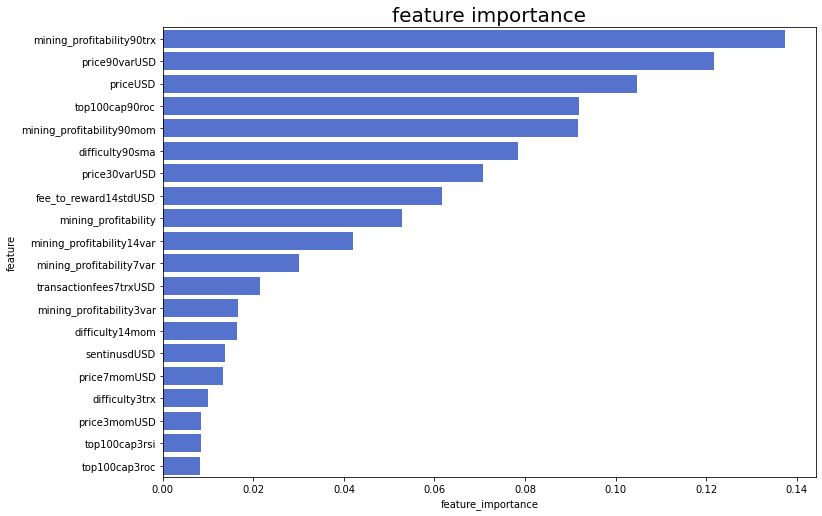

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


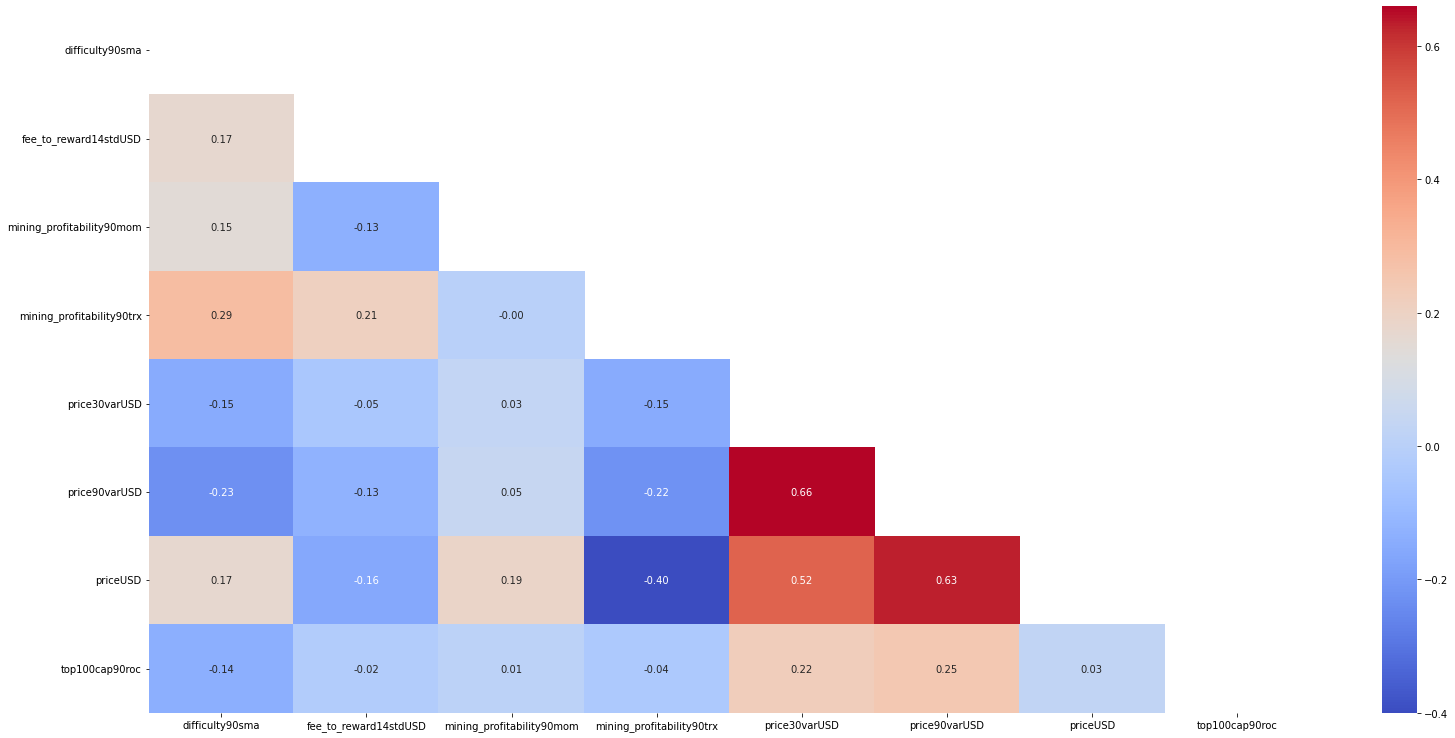

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


dropping 'hashrate3var' at index: 15
dropping 'size30sma' at index: 36
dropping 'transactions30wma' at index: 40
dropping 'transactions90std' at index: 40
dropping 'difficulty14std' at index: 6
dropping 'transactions90var' at index: 39
dropping 'hashrate' at index: 4
dropping 'sentbyaddress' at index: 2
dropping 'transactions' at index: 0
dropping 'confirmationtime' at index: 6
dropping 'activeaddresses' at index: 8
dropping 'transactionfeesUSD' at index: 4
dropping 'size' at index: 0
dropping 'fee_to_rewardUSD' at index: 7
dropping 'transactionvalueUSD' at index: 4
Remaining variables:
Index(['difficulty', 'mining_profitability', 'sentinusdUSD',
       'median_transaction_feeUSD', 'mediantransactionvalueUSD', 'top100cap'],
      dtype='object')


/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be 

dropping 'size90wma' at index: 44
dropping 'fee_to_reward14emaUSD' at index: 13
dropping 'fee_to_reward14wmaUSD' at index: 13
dropping 'fee_to_reward7emaUSD' at index: 13
dropping 'difficulty' at index: 0
Remaining variables:
Index(['mining_profitability', 'sentinusdUSD', 'median_transaction_feeUSD',
       'mediantransactionvalueUSD', 'top100cap', 'activeaddresses30mom',
       'confirmationtime30ema', 'confirmationtime3ema', 'confirmationtime7sma',
       'confirmationtime7wma', 'confirmationtime90ema', 'difficulty14var',
       'hashrate14mom', 'hashrate14trx', 'hashrate30roc', 'hashrate3std',
       'hashrate7trx', 'hashrate90mom', 'hashrate90roc', 'hashrate90rsi',
       'median_transaction_fee3trxUSD', 'median_transaction_fee7rocUSD',
       'mediantransactionvalue14rocUSD', 'mediantransactionvalue14rsiUSD',
       'mediantransactionvalue14smaUSD', 'mediantransactionvalue7rsiUSD',
       'mediantransactionvalue90smaUSD', 'mediantransactionvalue90trxUSD',
       'mining_profitabil

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


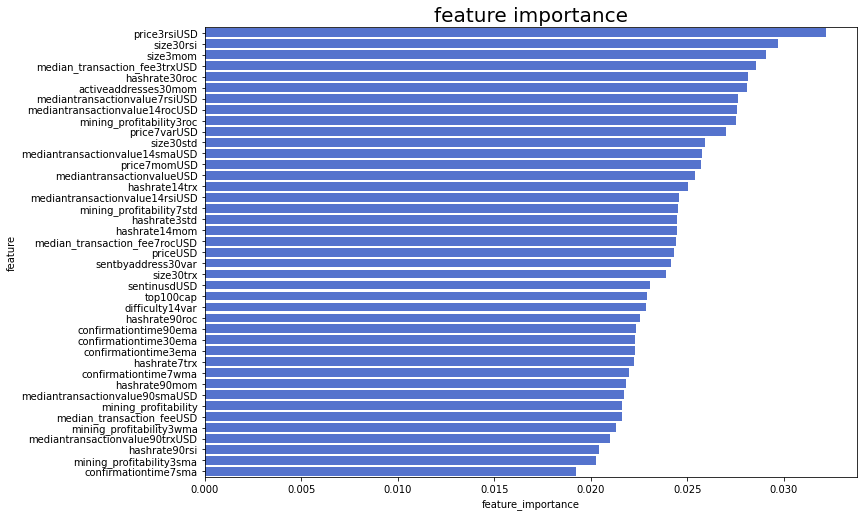

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


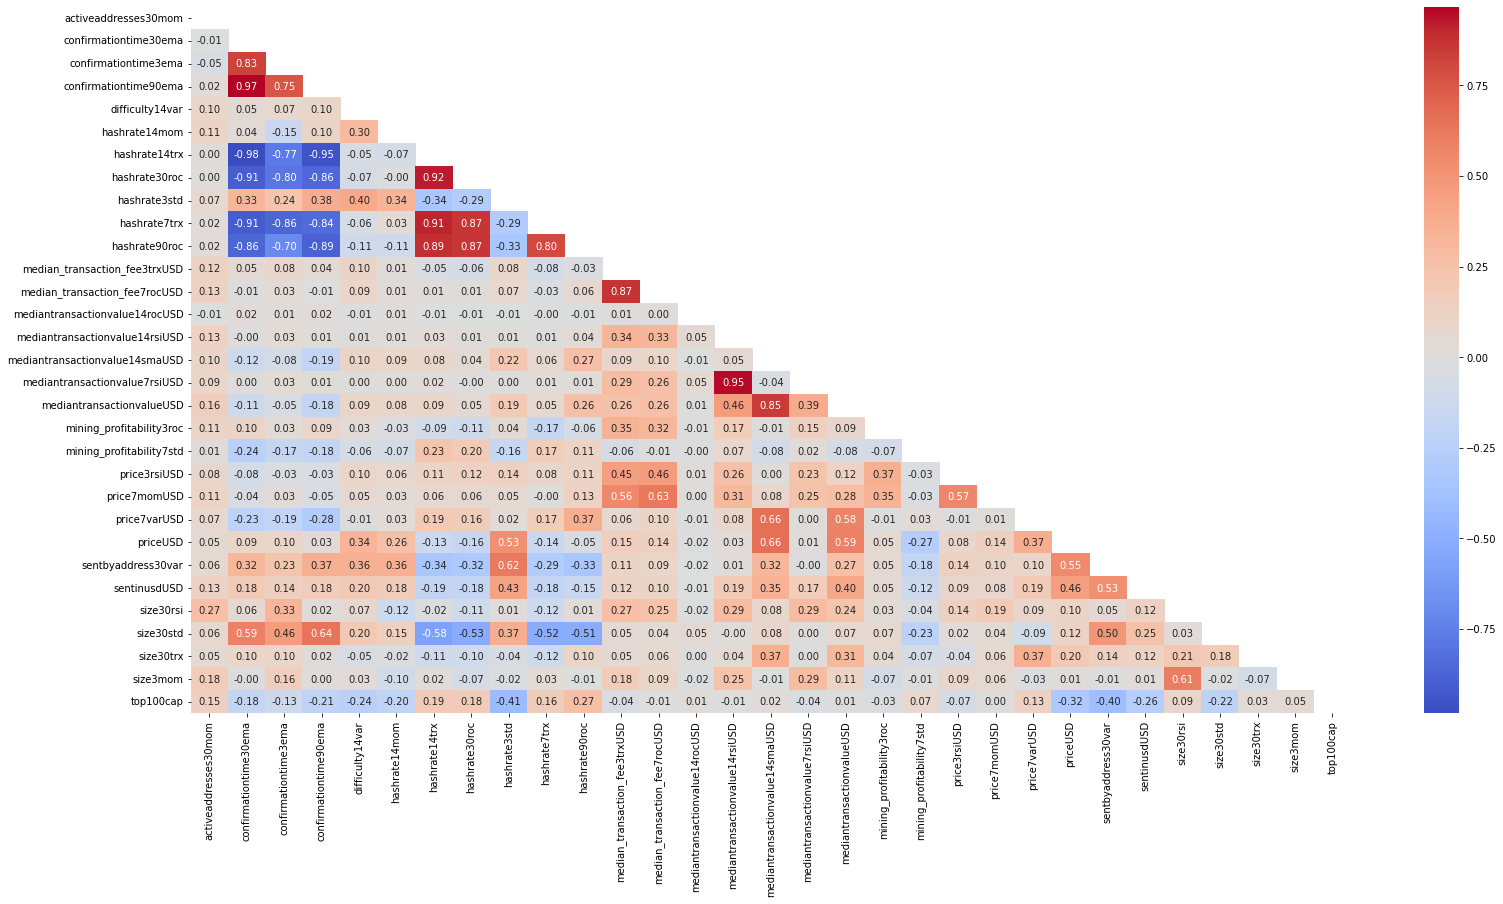

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


dropping 'hashrate7var' at index: 12
dropping 'hashrate' at index: 4
dropping 'sentbyaddress' at index: 2
dropping 'transactions' at index: 0
dropping 'confirmationtime' at index: 6
dropping 'activeaddresses' at index: 8
dropping 'transactionfeesUSD' at index: 4
dropping 'size' at index: 0
dropping 'fee_to_rewardUSD' at index: 7
dropping 'transactionvalueUSD' at index: 4
Remaining variables:
Index(['difficulty', 'mining_profitability', 'sentinusdUSD',
       'median_transaction_feeUSD', 'mediantransactionvalueUSD', 'top100cap'],
      dtype='object')


/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Remaining variables:
Index(['difficulty', 'mining_profitability', 'sentinusdUSD',
       'median_transaction_feeUSD', 'mediantransactionvalueUSD', 'top100cap',
       'activeaddresses30trx', 'difficulty14ema', 'difficulty3ema',
       'difficulty7ema', 'difficulty7trx', 'difficulty7wma', 'difficulty90std',
       'hashrate14std', 'hashrate14var', 'hashrate3std', 'hashrate3var',
       'hashrate7std', 'mining_profitability14sma',
       'mining_profitability14wma', 'mining_profitability30ema',
       'mining_profitability30sma', 'mining_profitability30wma',
       'mining_profitability3sma', 'mining_profitability3wma',
       'mining_profitability7sma', 'mining_profitability90ema',
       'mining_profitability90sma', 'mining_profitability90trx',
       'price30momUSD', 'price30stdUSD', 'price30varUSD', 'price3momUSD',
       'price3rsiUSD', 'price3trxUSD', 'price7momUSD', 'price7rocUSD',
       'price7rsiUSD', 'price90momUSD', 'price90rocUSD', 'sentinusd90varUSD',
       'top100cap14mom

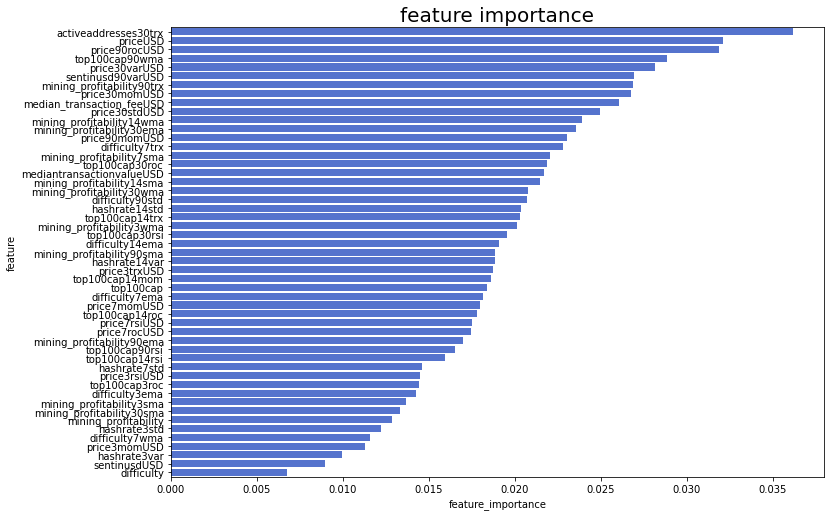

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


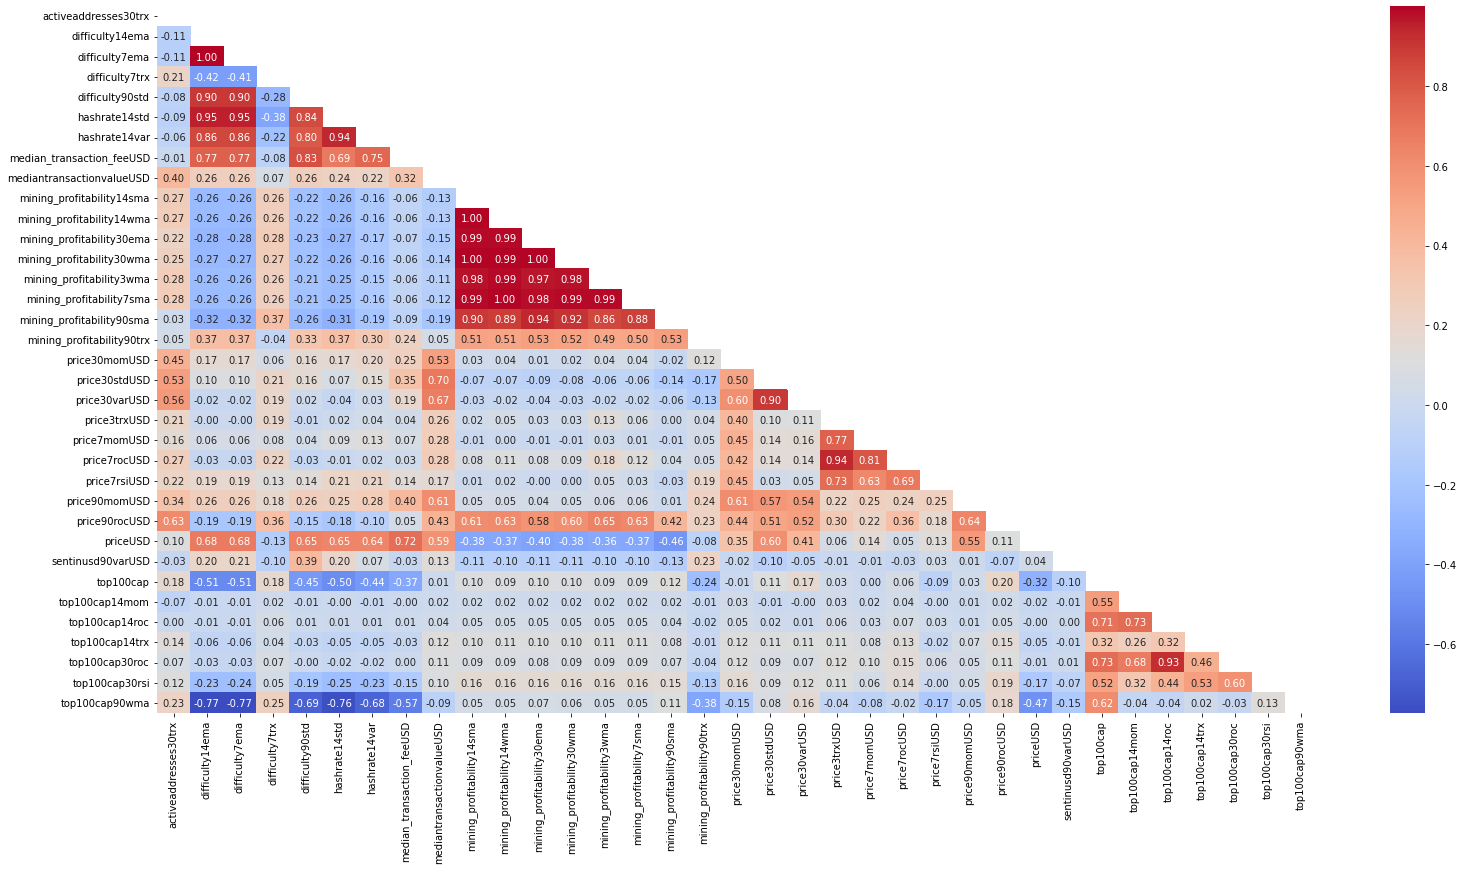

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


dropping 'hashrate7var' at index: 19
dropping 'hashrate' at index: 4
dropping 'sentbyaddress' at index: 2
dropping 'transactions' at index: 0
dropping 'confirmationtime' at index: 6
dropping 'activeaddresses' at index: 8
dropping 'transactionfeesUSD' at index: 4
dropping 'size' at index: 0
dropping 'fee_to_rewardUSD' at index: 7
dropping 'transactionvalueUSD' at index: 4
Remaining variables:
Index(['difficulty', 'mining_profitability', 'sentinusdUSD',
       'median_transaction_feeUSD', 'mediantransactionvalueUSD', 'top100cap'],
      dtype='object')


/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Remaining variables:
Index(['difficulty', 'mining_profitability', 'sentinusdUSD',
       'median_transaction_feeUSD', 'mediantransactionvalueUSD', 'top100cap',
       'difficulty14ema', 'difficulty14mom', 'difficulty14roc',
       'difficulty14sma', 'difficulty14trx', 'difficulty14wma',
       'difficulty3ema', 'difficulty7ema', 'difficulty7trx', 'difficulty7wma',
       'difficulty90mom', 'hashrate14std', 'hashrate14var', 'hashrate30trx',
       'hashrate30wma', 'hashrate3mom', 'hashrate3std', 'hashrate3var',
       'hashrate7std', 'median_transaction_fee3trxUSD',
       'mediantransactionvalue30smaUSD', 'mining_profitability30ema',
       'mining_profitability30std', 'mining_profitability3sma',
       'mining_profitability3wma', 'mining_profitability7sma',
       'mining_profitability90ema', 'mining_profitability90sma',
       'mining_profitability90std', 'mining_profitability90var',
       'mining_profitability90wma', 'price14rsiUSD', 'price30varUSD',
       'price3rocUSD', 'price3r

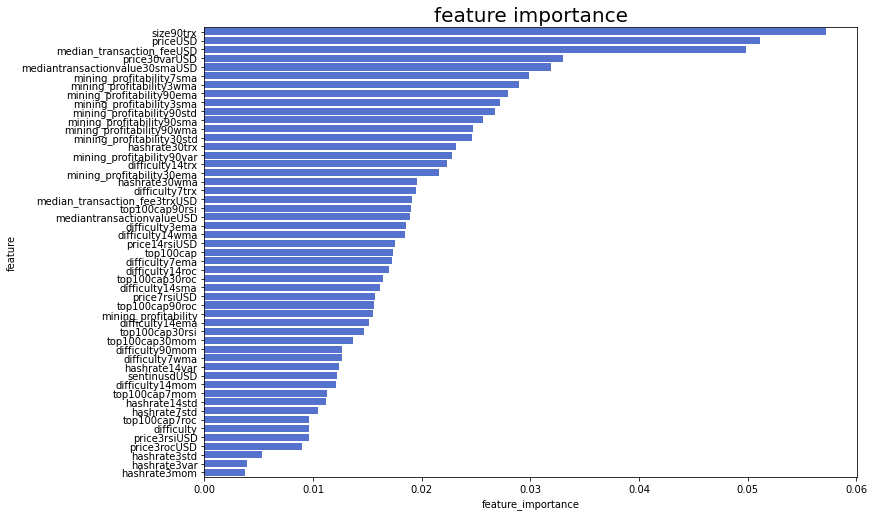

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


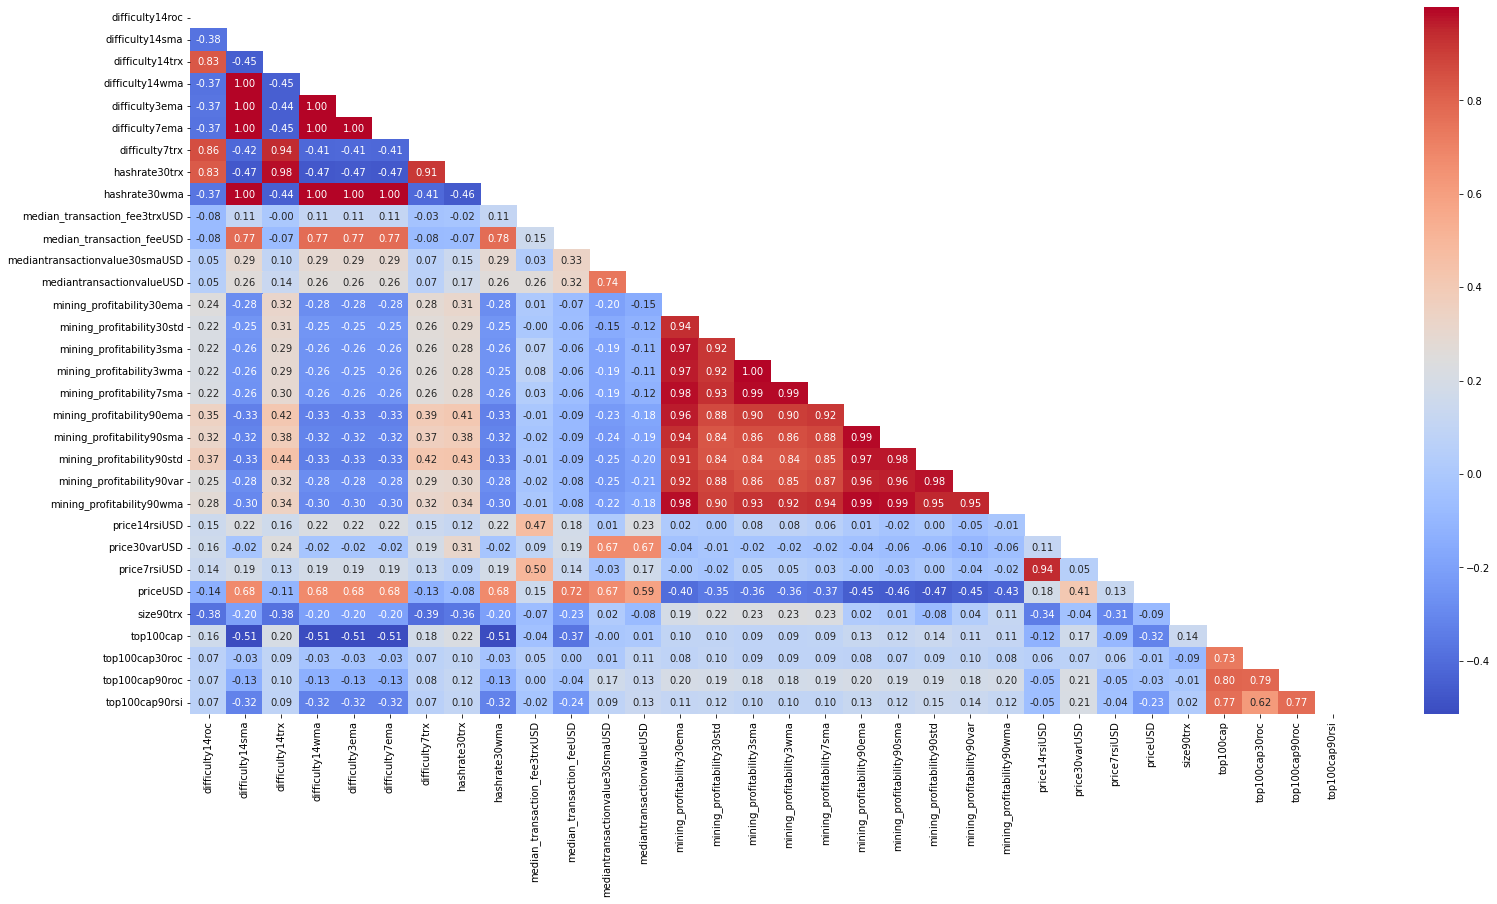

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


dropping 'hashrate7var' at index: 27
dropping 'hashrate' at index: 4
dropping 'sentbyaddress' at index: 2
dropping 'transactions' at index: 0
dropping 'confirmationtime' at index: 6
dropping 'activeaddresses' at index: 8
dropping 'transactionfeesUSD' at index: 4
dropping 'size' at index: 0
dropping 'fee_to_rewardUSD' at index: 7
dropping 'transactionvalueUSD' at index: 4
Remaining variables:
Index(['difficulty', 'mining_profitability', 'sentinusdUSD',
       'median_transaction_feeUSD', 'mediantransactionvalueUSD', 'top100cap'],
      dtype='object')


/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Remaining variables:
Index(['difficulty', 'mining_profitability', 'sentinusdUSD',
       'median_transaction_feeUSD', 'mediantransactionvalueUSD', 'top100cap',
       'difficulty14ema', 'difficulty14mom', 'difficulty14roc',
       'difficulty14rsi', 'difficulty14sma', 'difficulty14trx',
       'difficulty14wma', 'difficulty30ema', 'difficulty30roc',
       'difficulty30var', 'difficulty3ema', 'difficulty3trx', 'difficulty7ema',
       'difficulty7sma', 'difficulty7trx', 'difficulty90mom',
       'difficulty90std', 'fee_to_reward90smaUSD', 'hashrate14std',
       'hashrate14var', 'hashrate30sma', 'hashrate30trx', 'hashrate30wma',
       'hashrate3std', 'hashrate3var', 'hashrate7mom', 'hashrate7std',
       'hashrate90ema', 'mining_profitability30mom',
       'mining_profitability30std', 'mining_profitability3sma',
       'mining_profitability3wma', 'mining_profitability7wma',
       'mining_profitability90rsi', 'mining_profitability90trx',
       'mining_profitability90wma', 'price3momU

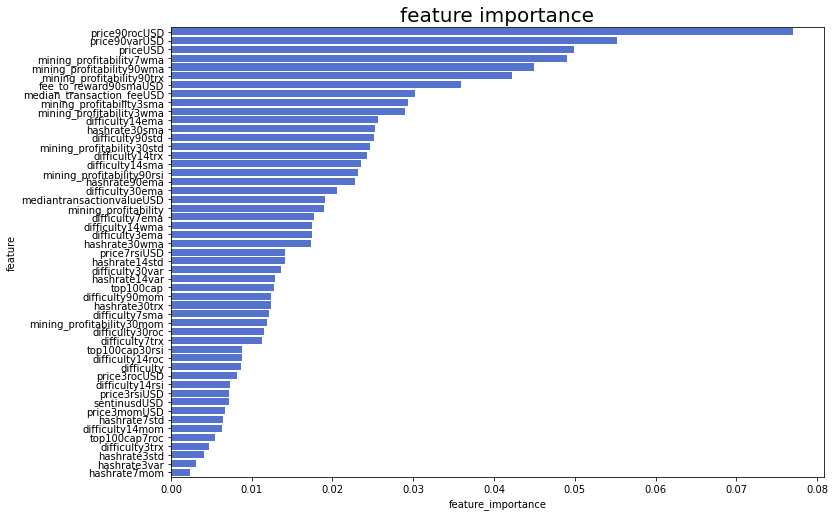

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


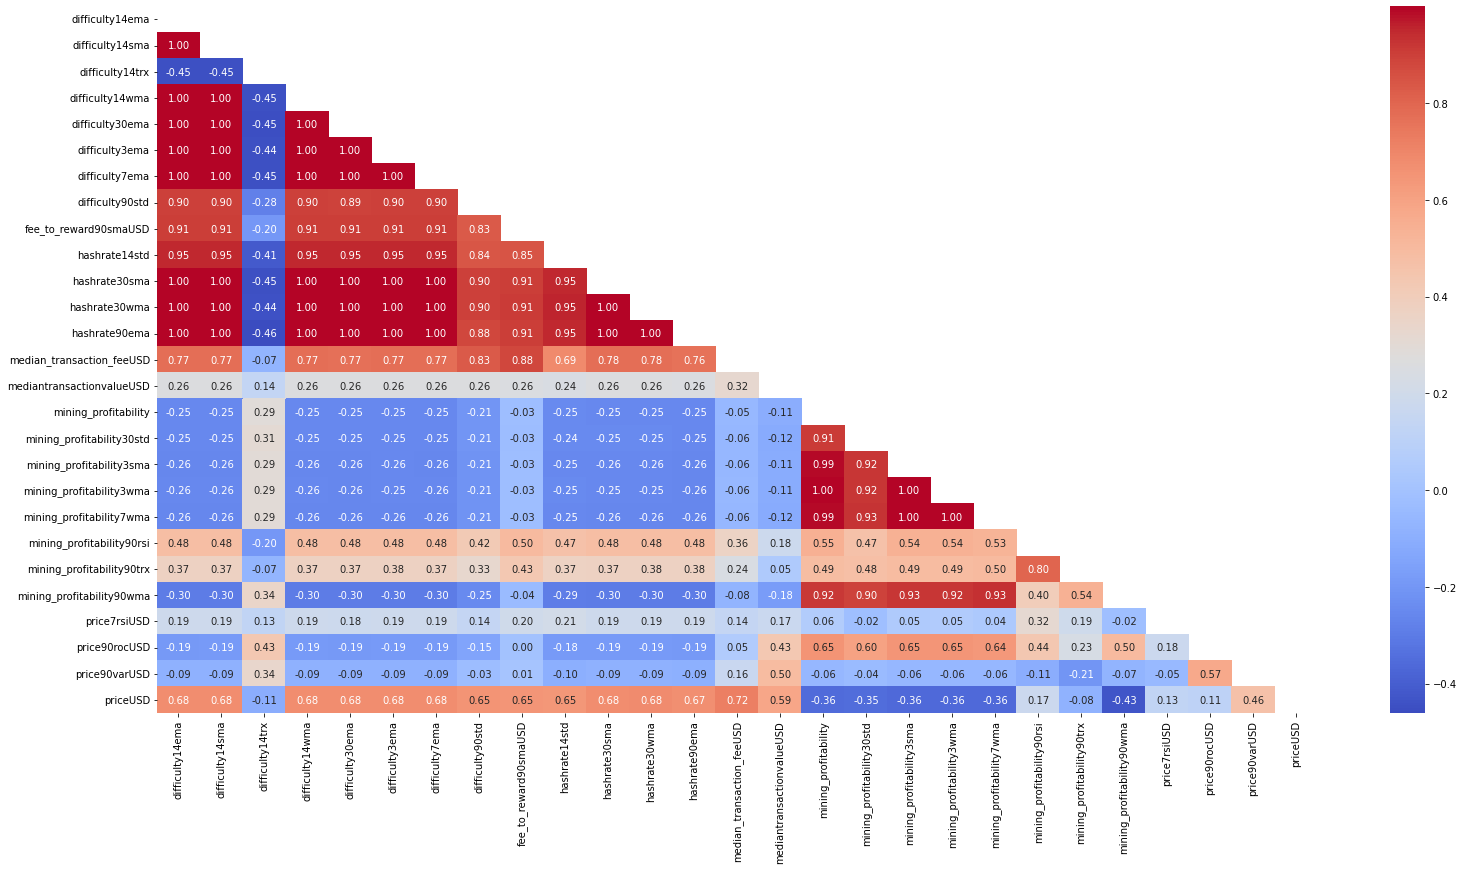

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


dropping 'hashrate14var' at index: 19
dropping 'difficulty90std' at index: 15
dropping 'hashrate' at index: 4
dropping 'sentbyaddress' at index: 2
dropping 'transactions' at index: 0
dropping 'confirmationtime' at index: 6
dropping 'activeaddresses' at index: 8
dropping 'transactionfeesUSD' at index: 4
dropping 'size' at index: 0
dropping 'fee_to_rewardUSD' at index: 7
dropping 'transactionvalueUSD' at index: 4
Remaining variables:
Index(['difficulty', 'mining_profitability', 'sentinusdUSD',
       'median_transaction_feeUSD', 'mediantransactionvalueUSD', 'top100cap'],
      dtype='object')


/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be 

Remaining variables:
Index(['difficulty', 'mining_profitability', 'sentinusdUSD',
       'median_transaction_feeUSD', 'mediantransactionvalueUSD', 'top100cap',
       'difficulty14mom', 'difficulty14roc', 'difficulty14rsi',
       'difficulty14sma', 'difficulty30ema', 'difficulty30mom',
       'difficulty30roc', 'difficulty30rsi', 'difficulty30sma',
       'difficulty30wma', 'difficulty3ema', 'difficulty7ema',
       'difficulty90ema', 'difficulty90mom', 'difficulty90rsi',
       'difficulty90var', 'difficulty90wma', 'hashrate14trx', 'hashrate3mom',
       'hashrate3std', 'hashrate3var', 'hashrate7mom', 'hashrate7std',
       'hashrate7var', 'mining_profitability14ema',
       'mining_profitability14std', 'mining_profitability14wma',
       'mining_profitability30std', 'mining_profitability30var',
       'mining_profitability3sma', 'mining_profitability3wma',
       'mining_profitability7sma', 'mining_profitability7wma',
       'mining_profitability90trx', 'price3rocUSD', 'price3rsiUSD

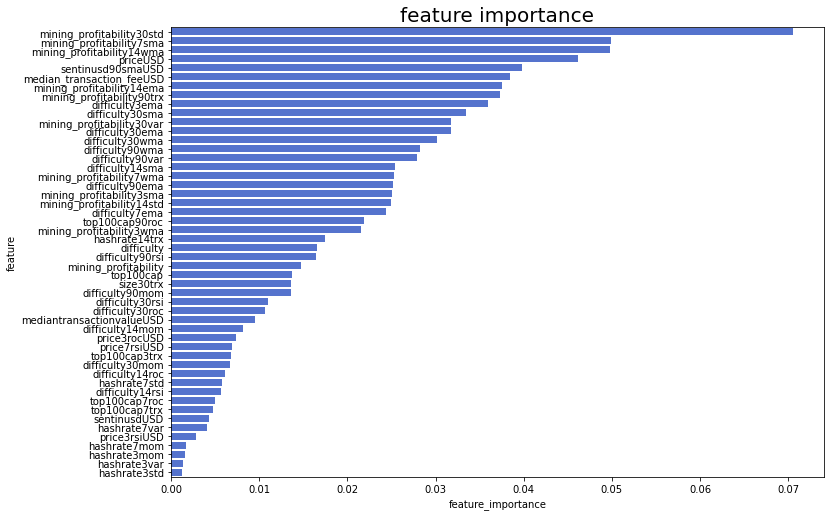

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


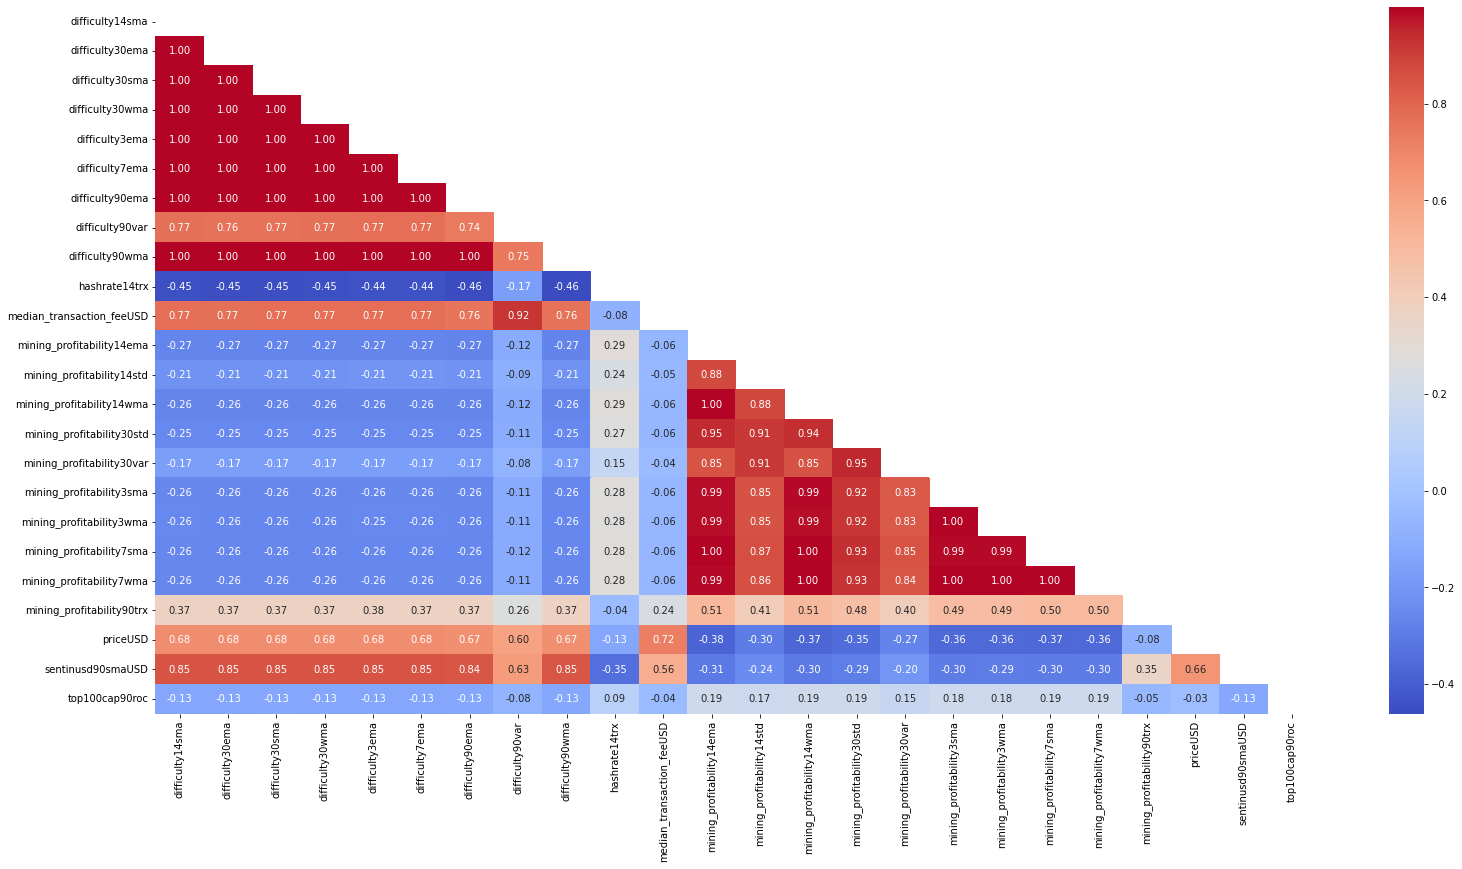

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


dropping 'hashrate' at index: 4
dropping 'sentbyaddress' at index: 2
dropping 'transactions' at index: 0
dropping 'confirmationtime' at index: 6
dropping 'activeaddresses' at index: 8
dropping 'transactionfeesUSD' at index: 4
dropping 'size' at index: 0
dropping 'fee_to_rewardUSD' at index: 7
dropping 'transactionvalueUSD' at index: 4
Remaining variables:
Index(['difficulty', 'mining_profitability', 'sentinusdUSD',
       'median_transaction_feeUSD', 'mediantransactionvalueUSD', 'top100cap'],
      dtype='object')


/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Remaining variables:
Index(['difficulty', 'mining_profitability', 'sentinusdUSD',
       'median_transaction_feeUSD', 'mediantransactionvalueUSD', 'top100cap',
       'activeaddresses90var', 'difficulty14ema', 'difficulty14mom',
       'difficulty14roc', 'difficulty14sma', 'difficulty14wma',
       'difficulty30ema', 'difficulty30mom', 'difficulty30roc',
       'difficulty30sma', 'difficulty3ema', 'difficulty3sma', 'difficulty3wma',
       'difficulty7ema', 'difficulty7rsi', 'difficulty7sma', 'difficulty7trx',
       'difficulty7wma', 'difficulty90ema', 'difficulty90rsi',
       'fee_to_reward30wmaUSD', 'fee_to_reward90smaUSD',
       'fee_to_reward90wmaUSD', 'hashrate14trx', 'hashrate30var',
       'hashrate7var', 'mining_profitability14std',
       'mining_profitability14var', 'mining_profitability30std',
       'mining_profitability3mom', 'mining_profitability3std',
       'mining_profitability3var', 'mining_profitability7mom',
       'mining_profitability7std', 'mining_profitabilit

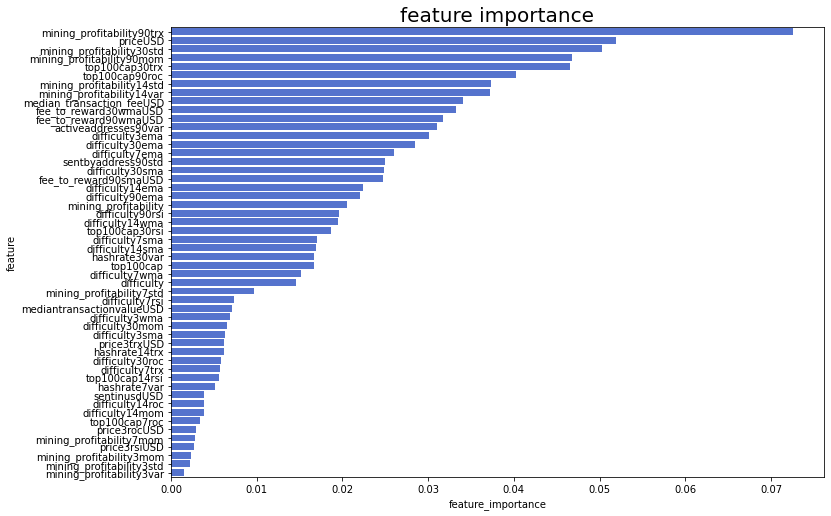

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


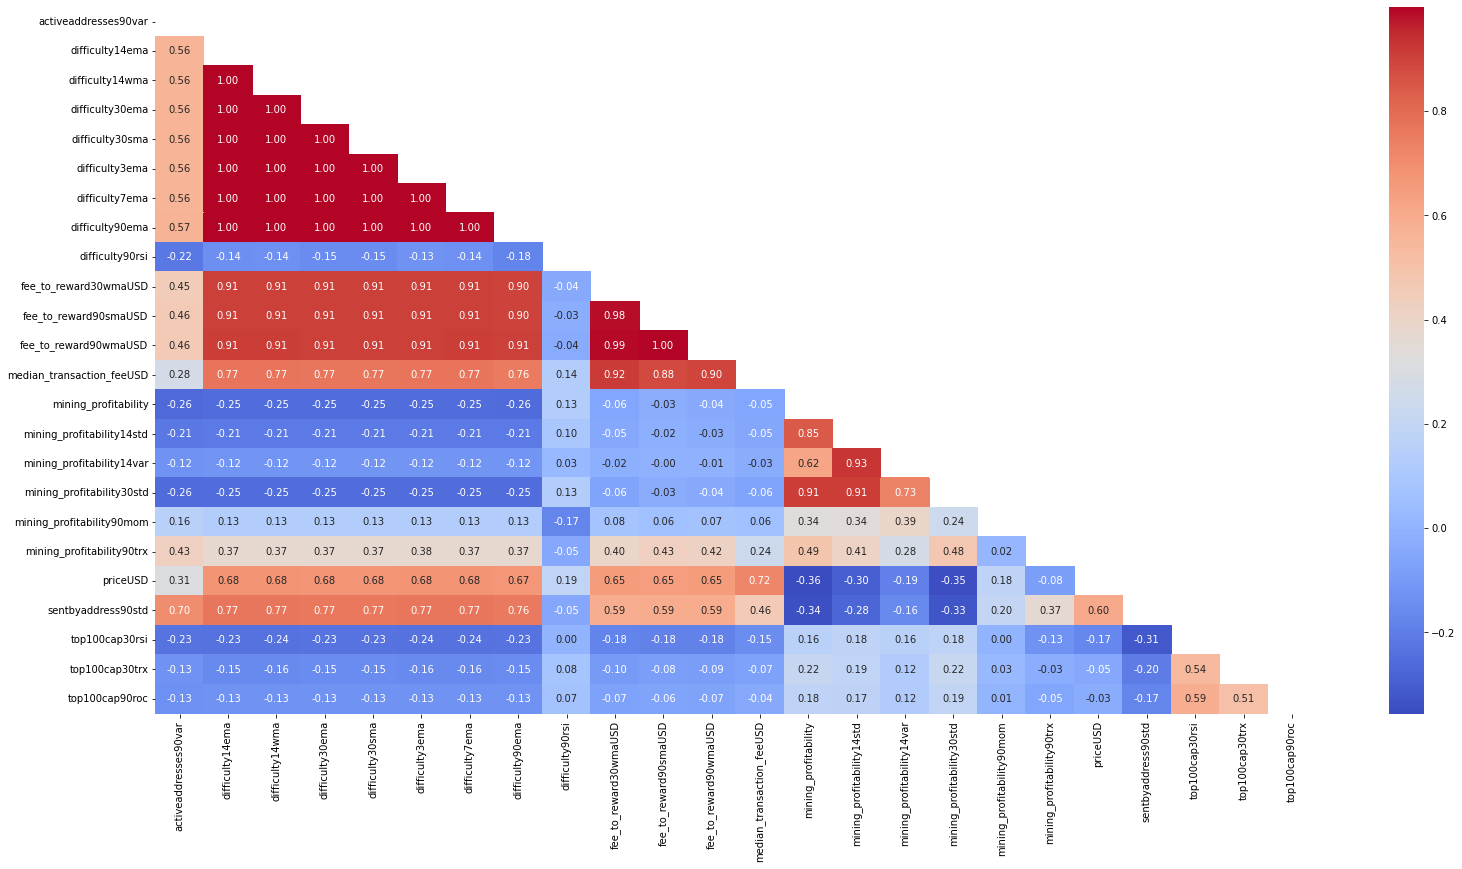

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


dropping 'hashrate30var' at index: 19
dropping 'difficulty14std' at index: 9
dropping 'hashrate30std' at index: 16
dropping 'hashrate' at index: 4
dropping 'transactionfeesUSD' at index: 6
dropping 'sentbyaddress' at index: 2
dropping 'sentinusdUSD' at index: 4
dropping 'size' at index: 1
Remaining variables:
Index(['transactions', 'difficulty', 'mining_profitability',
       'median_transaction_feeUSD', 'confirmationtime', 'transactionvalueUSD',
       'mediantransactionvalueUSD', 'activeaddresses', 'top100cap',
       'fee_to_rewardUSD'],
      dtype='object')


/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be 

dropping 'difficulty' at index: 1
Remaining variables:
Index(['transactions', 'mining_profitability', 'median_transaction_feeUSD',
       'confirmationtime', 'transactionvalueUSD', 'mediantransactionvalueUSD',
       'activeaddresses', 'top100cap', 'fee_to_rewardUSD',
       'activeaddresses30wma', 'activeaddresses7trx', 'confirmationtime14wma',
       'confirmationtime30sma', 'confirmationtime3ema', 'confirmationtime3wma',
       'confirmationtime7wma', 'confirmationtime90ema',
       'confirmationtime90wma', 'difficulty14var', 'fee_to_reward14emaUSD',
       'fee_to_reward3stdUSD', 'fee_to_reward7emaUSD', 'fee_to_reward7smaUSD',
       'hashrate14trx', 'hashrate30mom', 'hashrate30trx', 'hashrate7std',
       'mediantransactionvalue14momUSD', 'mediantransactionvalue14rocUSD',
       'mediantransactionvalue30emaUSD', 'mediantransactionvalue90trxUSD',
       'price14rsiUSD', 'price30rocUSD', 'price30rsiUSD', 'price3momUSD',
       'price3rocUSD', 'price3rsiUSD', 'price3trxUSD', 'price7m

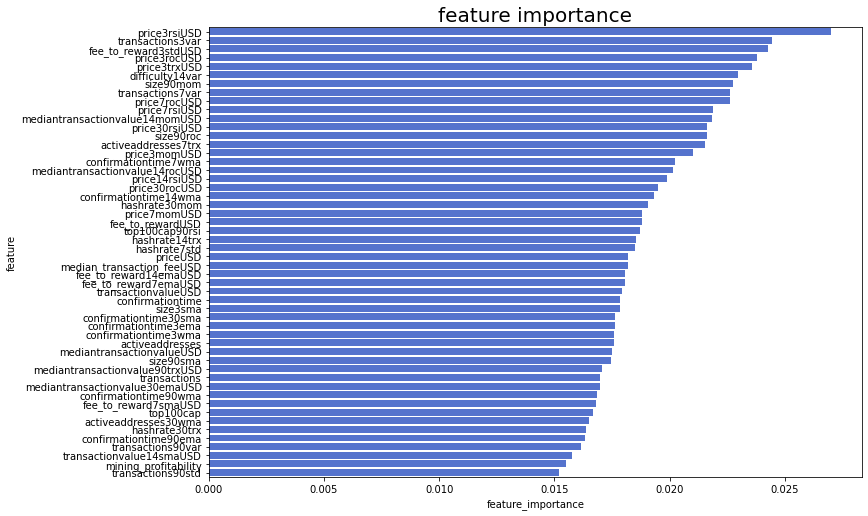

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


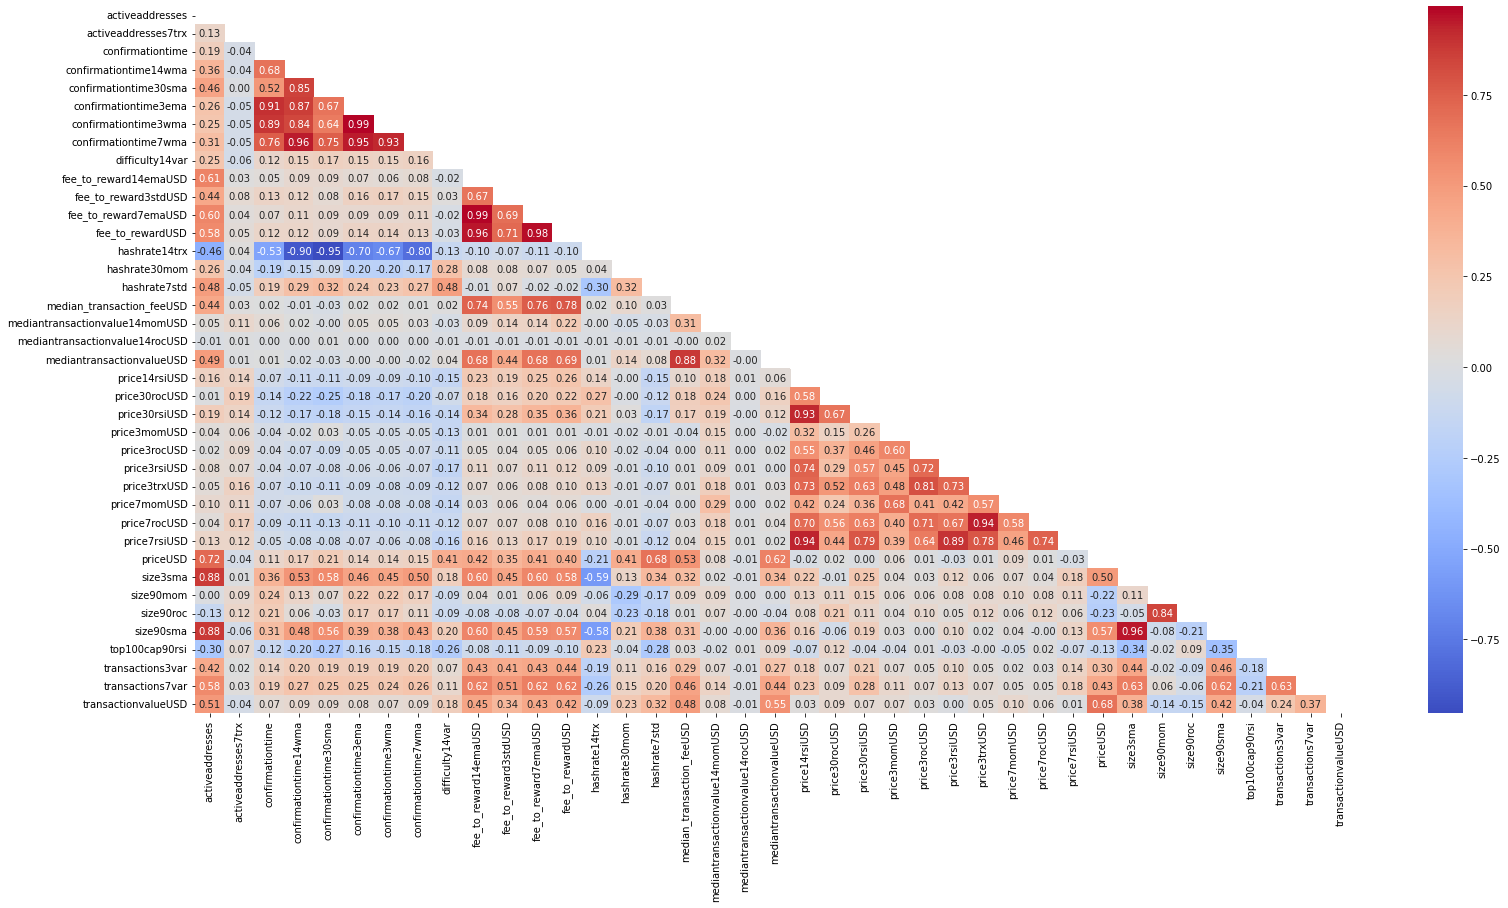

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


dropping 'difficulty90std' at index: 7
dropping 'hashrate7std' at index: 15
dropping 'hashrate3std' at index: 12
dropping 'hashrate' at index: 4
dropping 'transactionfeesUSD' at index: 6
dropping 'sentbyaddress' at index: 2
dropping 'sentinusdUSD' at index: 4
dropping 'size' at index: 1
Remaining variables:
Index(['transactions', 'difficulty', 'mining_profitability',
       'median_transaction_feeUSD', 'confirmationtime', 'transactionvalueUSD',
       'mediantransactionvalueUSD', 'activeaddresses', 'top100cap',
       'fee_to_rewardUSD'],
      dtype='object')


/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be 

Remaining variables:
Index(['transactions', 'difficulty', 'mining_profitability',
       'median_transaction_feeUSD', 'confirmationtime', 'transactionvalueUSD',
       'mediantransactionvalueUSD', 'activeaddresses', 'top100cap',
       'fee_to_rewardUSD', 'difficulty14sma', 'difficulty14trx',
       'difficulty14var', 'difficulty30ema', 'difficulty3trx',
       'difficulty7mom', 'difficulty7trx', 'difficulty90var',
       'fee_to_reward90trxUSD', 'hashrate14std', 'hashrate30trx',
       'hashrate3mom', 'hashrate3var', 'hashrate7sma', 'hashrate7var',
       'price14emaUSD', 'price14rocUSD', 'price14wmaUSD', 'price30smaUSD',
       'price30stdUSD', 'price30varUSD', 'price30wmaUSD', 'price3emaUSD',
       'price3rocUSD', 'price3rsiUSD', 'price3smaUSD', 'price3wmaUSD',
       'price7emaUSD', 'price7rocUSD', 'price7rsiUSD', 'price7wmaUSD',
       'price90emaUSD', 'price90momUSD', 'price90rocUSD', 'price90smaUSD',
       'price90wmaUSD', 'top100cap14mom', 'top100cap14rsi', 'top100cap30mom',


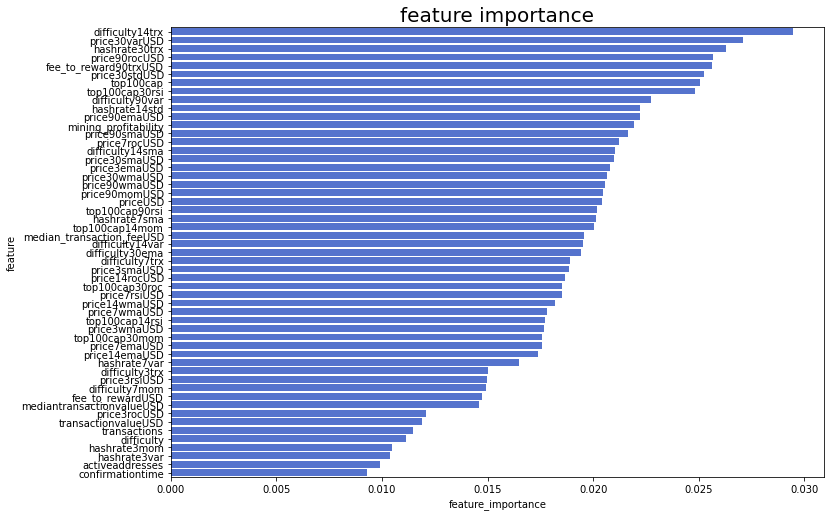

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


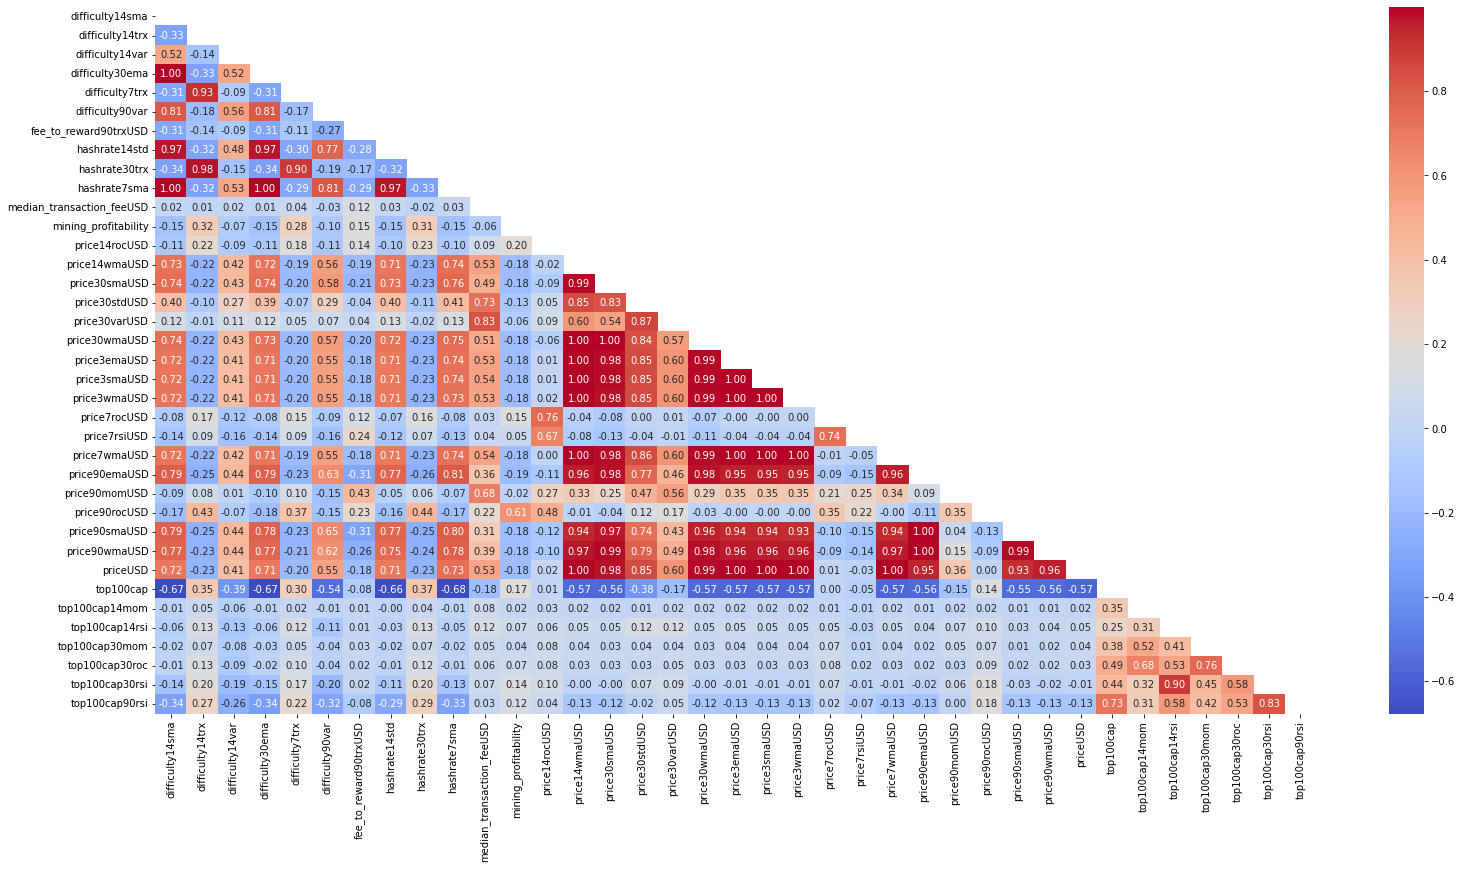

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


dropping 'difficulty14std' at index: 3
dropping 'difficulty30std' at index: 8
dropping 'difficulty90std' at index: 18
dropping 'hashrate7std' at index: 27
dropping 'hashrate3std' at index: 25
dropping 'hashrate' at index: 4
dropping 'transactionfeesUSD' at index: 6
dropping 'sentbyaddress' at index: 2
dropping 'sentinusdUSD' at index: 4
dropping 'size' at index: 1
Remaining variables:
Index(['transactions', 'difficulty', 'mining_profitability',
       'median_transaction_feeUSD', 'confirmationtime', 'transactionvalueUSD',
       'mediantransactionvalueUSD', 'activeaddresses', 'top100cap',
       'fee_to_rewardUSD'],
      dtype='object')


/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be 

Remaining variables:
Index(['transactions', 'difficulty', 'mining_profitability',
       'median_transaction_feeUSD', 'confirmationtime', 'transactionvalueUSD',
       'mediantransactionvalueUSD', 'activeaddresses', 'top100cap',
       'fee_to_rewardUSD', 'difficulty14ema', 'difficulty14mom',
       'difficulty14roc', 'difficulty14trx', 'difficulty14var',
       'difficulty14wma', 'difficulty30mom', 'difficulty30roc',
       'difficulty30var', 'difficulty3ema', 'difficulty3sma', 'difficulty3wma',
       'difficulty7ema', 'difficulty7mom', 'difficulty7trx', 'difficulty7wma',
       'difficulty90mom', 'difficulty90roc', 'difficulty90var',
       'fee_to_reward30emaUSD', 'fee_to_reward30smaUSD',
       'fee_to_reward3momUSD', 'fee_to_reward90emaUSD',
       'fee_to_reward90wmaUSD', 'hashrate30trx', 'hashrate3var',
       'hashrate7var', 'median_transaction_fee3rocUSD',
       'mining_profitability90trx', 'price14smaUSD', 'price30wmaUSD',
       'price3rsiUSD', 'price3trxUSD', 'price7rsiUS

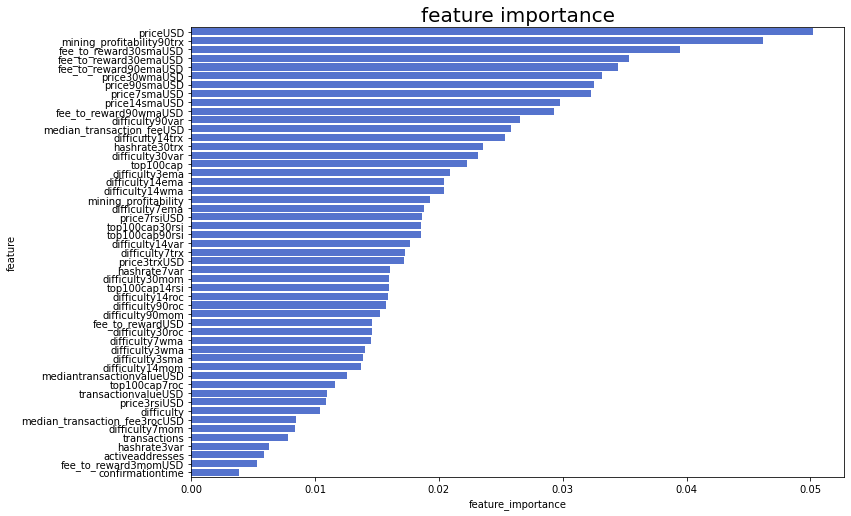

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


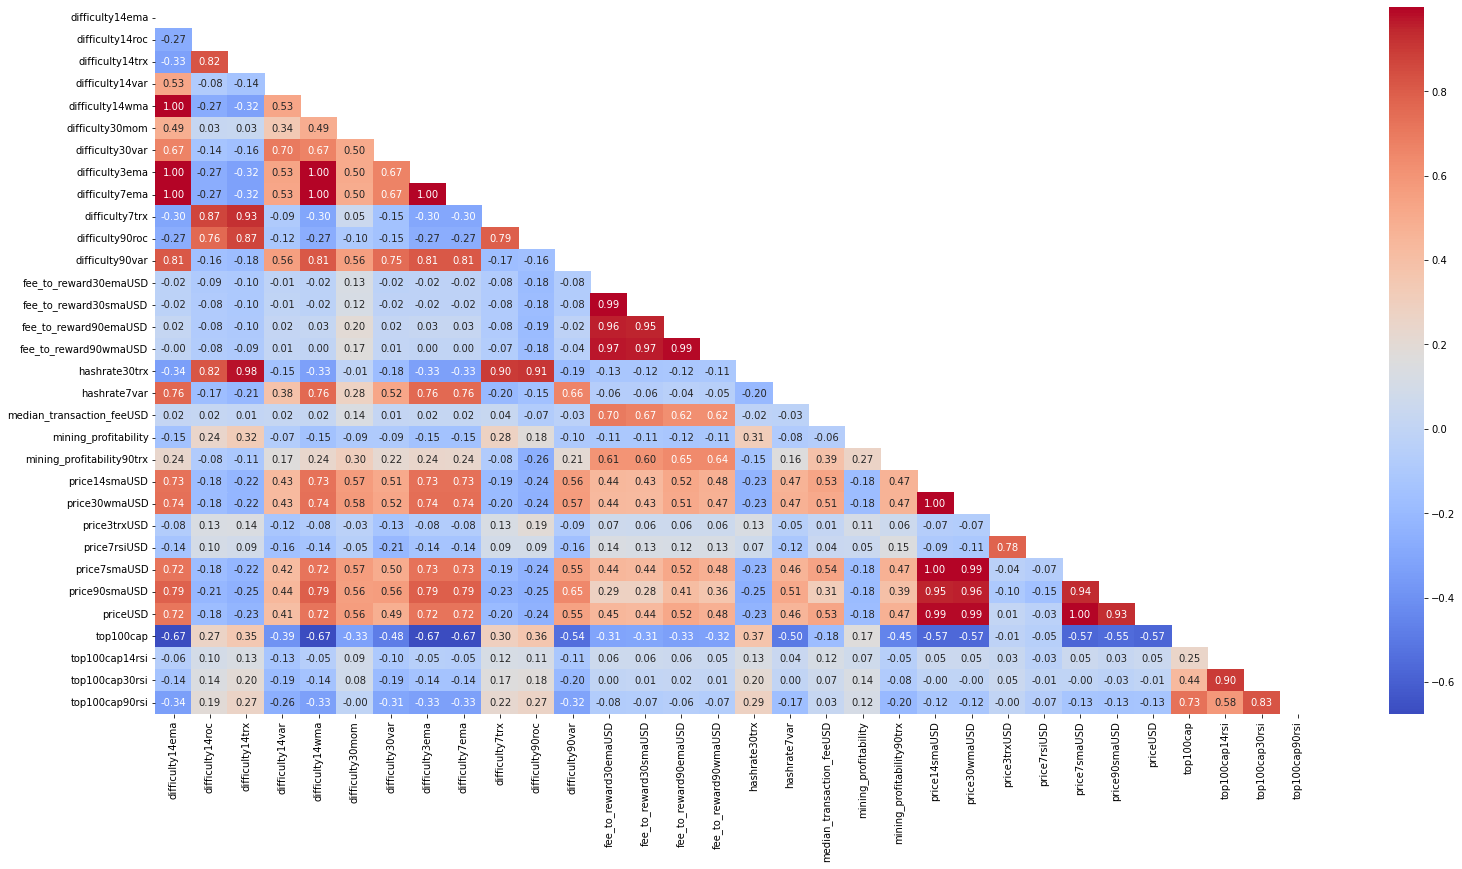

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


dropping 'hashrate7var' at index: 31
dropping 'difficulty30std' at index: 9
dropping 'hashrate14std' at index: 23
dropping 'hashrate3std' at index: 25
dropping 'hashrate7std' at index: 27
dropping 'hashrate' at index: 4
dropping 'transactionfeesUSD' at index: 6
dropping 'sentbyaddress' at index: 2
dropping 'sentinusdUSD' at index: 4
dropping 'size' at index: 1
Remaining variables:
Index(['transactions', 'difficulty', 'mining_profitability',
       'median_transaction_feeUSD', 'confirmationtime', 'transactionvalueUSD',
       'mediantransactionvalueUSD', 'activeaddresses', 'top100cap',
       'fee_to_rewardUSD'],
      dtype='object')


/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be 

Remaining variables:
Index(['transactions', 'difficulty', 'mining_profitability',
       'median_transaction_feeUSD', 'confirmationtime', 'transactionvalueUSD',
       'mediantransactionvalueUSD', 'activeaddresses', 'top100cap',
       'fee_to_rewardUSD', 'difficulty14ema', 'difficulty14mom',
       'difficulty14roc', 'difficulty14sma', 'difficulty14wma',
       'difficulty30ema', 'difficulty30mom', 'difficulty30roc',
       'difficulty30sma', 'difficulty30trx', 'difficulty30var',
       'difficulty3ema', 'difficulty3sma', 'difficulty3trx', 'difficulty3wma',
       'difficulty7ema', 'difficulty7sma', 'difficulty7trx', 'difficulty7wma',
       'difficulty90mom', 'difficulty90roc', 'difficulty90var',
       'difficulty90wma', 'hashrate14trx', 'hashrate14var', 'hashrate3var',
       'hashrate7mom', 'mining_profitability90trx', 'price30wmaUSD',
       'price3momUSD', 'price3rocUSD', 'price3rsiUSD', 'price7rsiUSD',
       'price90emaUSD', 'price90smaUSD', 'sentinusd90stdUSD', 'top100cap14rs

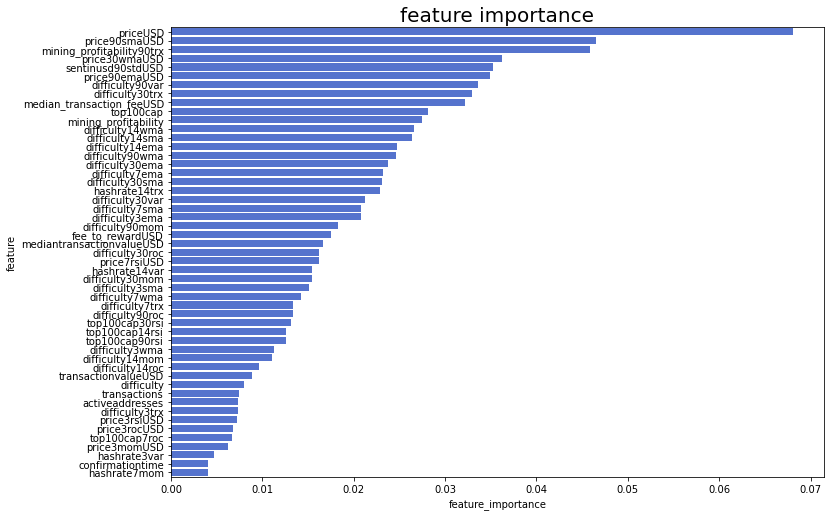

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


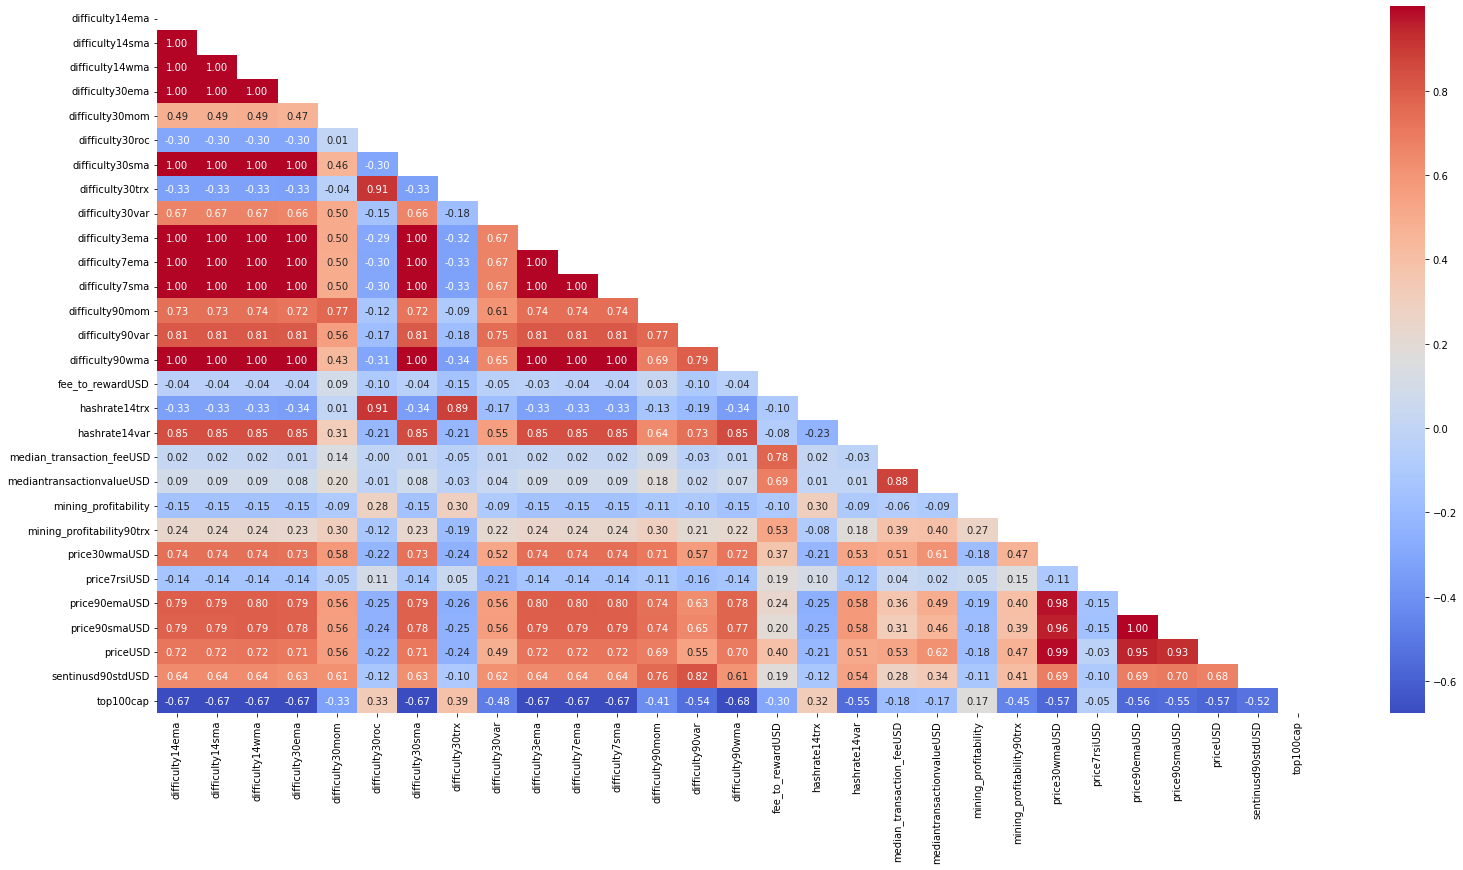

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


dropping 'hashrate14var' at index: 14
dropping 'hashrate7std' at index: 18
dropping 'hashrate30std' at index: 14
dropping 'difficulty90std' at index: 10
dropping 'hashrate3std' at index: 14
dropping 'difficulty30sma' at index: 5
dropping 'difficulty30wma' at index: 5
dropping 'difficulty30ema' at index: 2
dropping 'hashrate' at index: 4
dropping 'transactionfeesUSD' at index: 6
dropping 'sentbyaddress' at index: 2
dropping 'sentinusdUSD' at index: 4
dropping 'size' at index: 1
Remaining variables:
Index(['transactions', 'difficulty', 'mining_profitability',
       'median_transaction_feeUSD', 'confirmationtime', 'transactionvalueUSD',
       'mediantransactionvalueUSD', 'activeaddresses', 'top100cap',
       'fee_to_rewardUSD'],
      dtype='object')


/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be 

dropping 'difficulty' at index: 1
Remaining variables:
Index(['transactions', 'mining_profitability', 'median_transaction_feeUSD',
       'confirmationtime', 'transactionvalueUSD', 'mediantransactionvalueUSD',
       'activeaddresses', 'top100cap', 'fee_to_rewardUSD', 'difficulty14mom',
       'difficulty14roc', 'difficulty30mom', 'difficulty30roc',
       'difficulty7mom', 'difficulty7trx', 'difficulty90rsi',
       'difficulty90var', 'fee_to_reward14stdUSD', 'fee_to_reward3momUSD',
       'hashrate30var', 'hashrate3var', 'hashrate7var',
       'median_transaction_fee3rocUSD', 'median_transaction_fee3trxUSD',
       'median_transaction_fee7rocUSD', 'mining_profitability90trx',
       'price14emaUSD', 'price14rsiUSD', 'price14smaUSD', 'price14wmaUSD',
       'price30rsiUSD', 'price3emaUSD', 'price3rsiUSD', 'price3smaUSD',
       'price3wmaUSD', 'price7emaUSD', 'price7rsiUSD', 'price7smaUSD',
       'price7wmaUSD', 'price90emaUSD', 'price90smaUSD', 'price90wmaUSD',
       'top100cap14tr

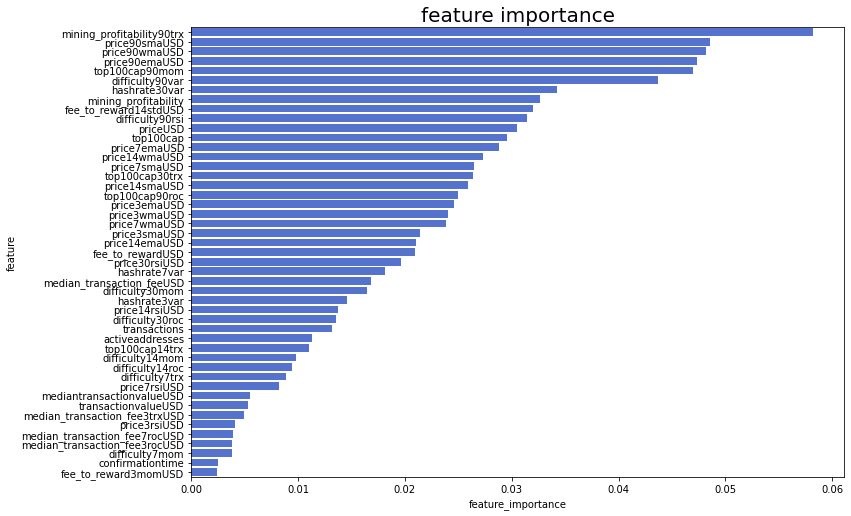

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


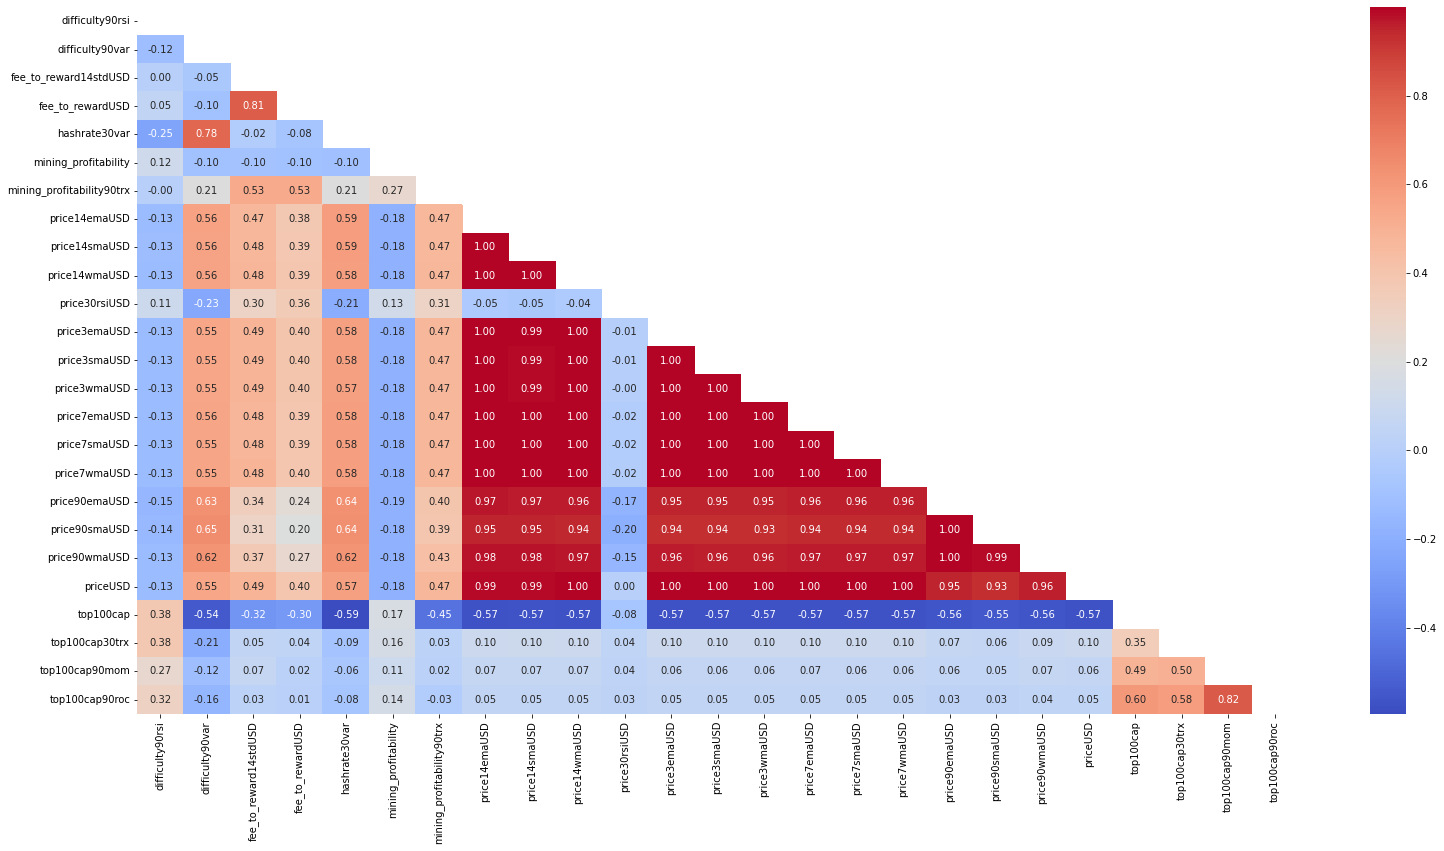

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


dropping 'hashrate14var' at index: 6
dropping 'hashrate7std' at index: 11
dropping 'hashrate30std' at index: 6
dropping 'difficulty90std' at index: 3
dropping 'hashrate3std' at index: 6
dropping 'hashrate14std' at index: 4
dropping 'hashrate' at index: 4
dropping 'transactionfeesUSD' at index: 6
dropping 'sentbyaddress' at index: 2
dropping 'sentinusdUSD' at index: 4
dropping 'size' at index: 1
Remaining variables:
Index(['transactions', 'difficulty', 'mining_profitability',
       'median_transaction_feeUSD', 'confirmationtime', 'transactionvalueUSD',
       'mediantransactionvalueUSD', 'activeaddresses', 'top100cap',
       'fee_to_rewardUSD'],
      dtype='object')


/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be 

dropping 'difficulty' at index: 1
Remaining variables:
Index(['transactions', 'mining_profitability', 'median_transaction_feeUSD',
       'confirmationtime', 'transactionvalueUSD', 'mediantransactionvalueUSD',
       'activeaddresses', 'top100cap', 'fee_to_rewardUSD', 'difficulty14mom',
       'difficulty14roc', 'difficulty30mom', 'difficulty90var',
       'hashrate30var', 'hashrate3var', 'hashrate7mom', 'hashrate7var',
       'median_transaction_fee3rocUSD', 'median_transaction_fee3trxUSD',
       'mining_profitability90trx', 'price14emaUSD', 'price14smaUSD',
       'price14wmaUSD', 'price30emaUSD', 'price30smaUSD', 'price30wmaUSD',
       'price3emaUSD', 'price3momUSD', 'price3rsiUSD', 'price3smaUSD',
       'price3wmaUSD', 'price7emaUSD', 'price7rocUSD', 'price7rsiUSD',
       'price7smaUSD', 'price7wmaUSD', 'price90emaUSD', 'price90smaUSD',
       'price90wmaUSD', 'top100cap14rsi', 'top100cap14trx', 'top100cap30roc',
       'top100cap30rsi', 'top100cap30trx', 'top100cap7trx', 'top1

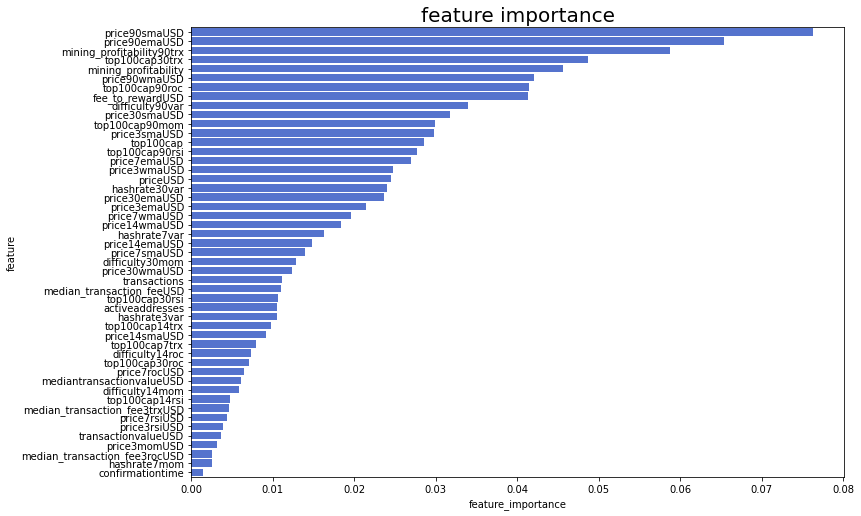

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


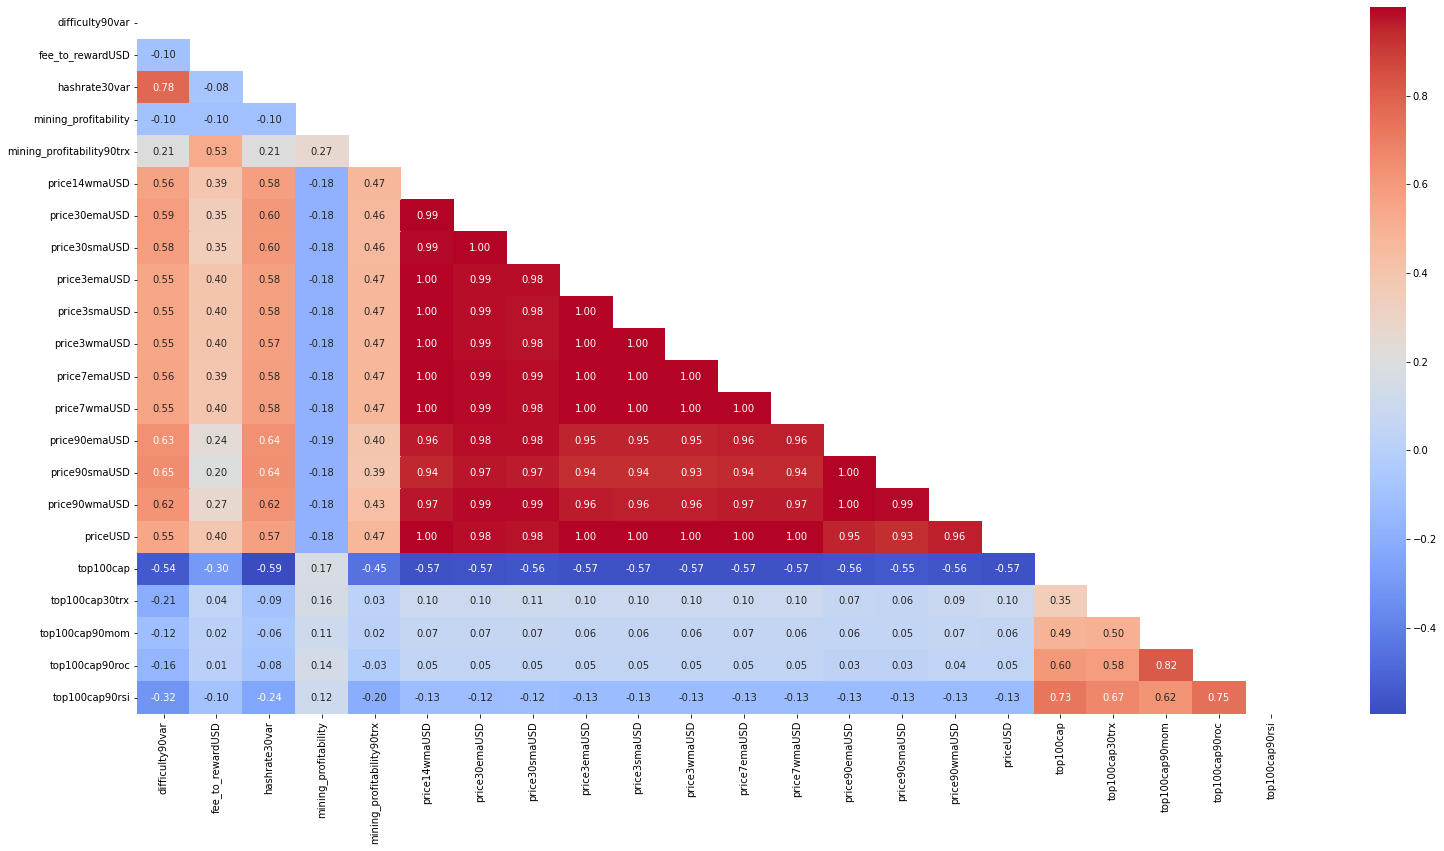

/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/mariana/.virtualenvs/time-series-proj/lib/python3.6/site-packages/ipykernel_launcher.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
technical_indicators=['sma','ema','wma','trx','mom','std','var','rsi','roc']
periods=['3','7','14','30','90']

for interval in intervals_masks_map:
    for shifting in shifted_prices_map:

        # ---- BUILD SHIFTED DATASET ACCORDING TO PERIOD ----
        df = data.loc[
            intervals_masks_map[interval]
        ]

        df = df.assign(
            shifted=
            shifted_prices_map[shifting].loc[intervals_masks_map[interval]]
            )

        df.loc[:, 'difference']=((df['shifted']-df['priceUSD'])/df['shifted'])*100
        df.reset_index(drop=True,inplace=True)
        df.loc[:, "category"] = df['difference']>=0
        df["category"].replace({
                True: 1,
                False: 0
            },
            inplace=True
            )
        df.drop(columns=['shifted','difference'],inplace=True)

        # ---- FEATURE SELECTION ----
        USD=df['priceUSD']
        X_raw=df.iloc[:,2:17]

        # Category Array
        y=df.loc[:, "category"]
        y=np.ravel(y)
        
        # Get most important feature for each technical indicator combination
        # <period><technical_indicator> ie. 30sma, 9roc
        features_list=[]
        for i in technical_indicators:
            for j in periods:
                string=str(j)+str(i)
                X=df.filter(like=string,axis=1)
                X=SimpleImputer(missing_values=0,strategy='most_frequent').fit_transform(X)
                X=pd.DataFrame(X)
                X.columns=df.filter(like=string,axis=1).columns
                rf1=RandomForestClassifier(random_state=7,n_jobs=-1)
                rfecv=RFECV(rf1,step=0.9,min_features_to_select=1,verbose=0,cv=5,scoring='neg_mean_absolute_error', n_jobs=-1)
                rfecv.fit(X,y)
                if rfecv.n_features_>1:
                    rf1.fit(X,y)
                    maximp=rf1.feature_importances_.max()
                    for x in range(len(rf1.feature_importances_)):
                        if maximp==rf1.feature_importances_[x]:
                            new_features = [X.columns[x]]
                else:
                    mask = rfecv.get_support()
                    new_features = X.columns[mask].array
                features_list.extend(new_features)
    
        # Not needed anymore. Same as feature_list. But maintain just in case
        l1=[]
        for j in range(len(features_list)):
            result1 = re.search("'(.*)'],", features_list[j])
            if result1!=None:
                l1.append(result1.group(1))
        for i in range(len(features_list)):
            result2 = re.search('.*',features_list[i])
            if len(result2.group(0))<33:
                l1.append(result2.group(0))

        l1.sort()
        df_reduced=df[l1]
        df_reduced.head()

        # Drop high collinear variables for reduced dataset
        X=cmns.drop_high_vif(df_reduced,thresh=5, print_result=False)
        cmns.vif_values(X)
        X.shape
        
        # Drop high collinear variables for raw dataset
        Raw=cmns.drop_high_vif(X_raw,thresh=10)
        cmns.vif_values(Raw)
        
        Raw.loc[:, 'Date']=df['Date']
        X['Date']=df['Date']

        # Drop high collinear variables for merged (reduced + raw) dataset
        df_merged=Raw.merge(X.drop_duplicates(subset='Date'),how='left')
        df_merged.drop(columns='Date',inplace=True)
        X=cmns.drop_high_vif(df_merged,thresh=5)
        cmns.vif_values(X)

        if 'priceUSD' not in X.columns:
            X['priceUSD']=USD

        # Train final random forest with new subset
        rf_final=RandomForestClassifier(random_state=7,n_jobs=-1)
        rf_final.fit(X,y)
        imp_feat=cmns.feature_importance(X.columns,rf_final.feature_importances_)
        cmns.plot_feature_importance(imp_feat,'feature importance')
        plt.show()

        # Select features that sum up to 80% of feature importance
        imp_feat_cumsum = imp_feat.copy()
        imp_feat_cumsum.loc[:, "feature_importance_cumsum"] = imp_feat_cumsum["feature_importance"].expanding(1).sum()
        select_with_cumsum = imp_feat_cumsum[imp_feat_cumsum["feature_importance_cumsum"] <= 0.80]

        X_high=X[select_with_cumsum.feature]
        X_high.sort_index(axis=1,inplace=True)
        
        # Set up the matplotlib figure and show correlation matrix
        corr = X_high.corr()
        # Generate a mask for the upper triangle
        mask = np.triu(np.ones_like(corr, dtype=np.bool))
        f, ax = plt.subplots(figsize=(26, 13))
        sns.heatmap(corr,mask=mask, cmap='coolwarm',annot=True, fmt='.2f')
        plt.show()

        X_high['category']=np.ravel(y)

        # ---- REMOVE OUTLIERS ----
        from sklearn.ensemble import IsolationForest
        outlier=IsolationForest(contamination=0)
        category=X_high['category']
        category=category.values
        category=np.reshape(category,(-1,1))
        outlier.fit(category)
        outs=outlier.predict(category)
        X_high['outlier']=pd.DataFrame(zip(outs))
        X_high=X_high.query('outlier != -1')
        X_high.reset_index(drop=True,inplace=True)
        X_high.drop(columns=['outlier'],inplace=True)

        # ---- SAVE DATASET ----
        X_high.to_csv(f'datasets/cls_{interval}_{shifting}days.csv',sep=',',index=False)
        